<a href="https://colab.research.google.com/github/EPVIAX/LCC_Shovel/blob/main/MARC_C_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xlsxwriter
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import numpy as np

In [ ]:

# Replace 'Tarifas.xlsx' with the actual path to your file if it's not in the same directory
file_path = 'Tarifas.xlsx'
sheet_name = '794AC'

try:
    # Read the specific sheet into a pandas DataFrame
    df_794AC = pd.read_excel(file_path, sheet_name=sheet_name)

    # Now you have the data from the '794AC' sheet in the df_794AC DataFrame.
    # You can now process this DataFrame to match the format of 'Tarifa_794AC'.
    # For example, you might need to rename columns, filter rows, or change data types.

    print(f"Successfully read the sheet '{sheet_name}' from '{file_path}'.")
    print("First 5 rows of the DataFrame:")
    display(df_794AC.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please make sure it's uploaded.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read the sheet '794AC' from 'Tarifas.xlsx'.
First 5 rows of the DataFrame:


,Haul Truck Caterpillar 794AC,"0 to 7,000","7,001 to 14,000","14,001 to 21,000","21,001 to 28,000","28,001 to 35,000","35,001 to 42,000","42,001 to 49,000","49,001 to 56,000","56,001 to 63,000","63,001 to 70,000","70,001 to 77,000"
0,Imported Parts,18.073547,42.196158,42.196158,42.196158,44.499167,49.790000,49.790000,49.790000,52.064105,52.064105,52.064105
1,Major Parts and Components,0.000000,0.000000,314.821206,78.897845,51.710000,157.070000,77.680000,324.630000,189.330000,57.240000,57.240000
2,AHS and Terrain Parts,3.068827,9.858155,9.858155,9.858155,12.900000,66.289137,25.610257,20.148176,27.983174,17.706660,17.706660


In [ ]:

def adjust_number(number):
  """
  Adjusts a number based on its units digit.

  Args:
    number: The integer number to adjust.

  Returns:
    The adjusted integer number.
  """
  if number % 10 == 1:
    # If the units digit is 1, subtract 1
    return number - 1
  else:
    # Otherwise (if the units digit is 0 or any other digit), keep the number as is
    # Note: Based on your description, you only specified 0 and 1.
    # This code assumes if it's not 1, it stays the same.
    return number

def extraer_numeros(text):

    # Use a regular expression to find all numbers (integers or decimals) in the string
    # \d+ matches one or more digits
    # ,? matches an optional comma
    pattern = r'\d+,?\d*'
    numbers = re.findall(pattern, text)

    # Convert the extracted strings to integers or floats if needed
    # Remove commas before converting
    cleaned_numbers = [num.replace(',', '') for num in numbers]
    # Assuming the numbers represent integers
    integer_numbers = [int(num) for num in cleaned_numbers]
    for i in range(len(integer_numbers)):
        integer_numbers[i] = adjust_number(integer_numbers[i])
    return integer_numbers

def convertir_tarifas(file_path,sheet_name):
    """
    Extrae de un excel la tabla de tarifas
    Crea un data frame con el modelo del equipo
    Tambien retorna el modelo del equiop y el rango de horas para tarifa
    Guarda una hoja en el mismo archivo excel con el nombre 'Tarifas_modeloequipo'
    """

    #Leer la hoja del archivo excel
    df_original = pd.read_excel(file_path, sheet_name=sheet_name)
    #Extraer el modelo del equipo
    modelo_equipo = df_original.columns[0]
    print('Modelo de equipo en proceso ...', modelo_equipo)
    # Use pd.melt() to unpivot the DataFrame
    df_final = pd.melt(df_original,
                        id_vars=[modelo_equipo],  # The column(s) to keep as identifiers
                        var_name='Rango_horas', # Name for the new column that will hold the original column headers
                        value_name='Tarifa')   # Name for the new column that will hold the values

    # Añadir la columna 'Modelo' con el valor extraido del modelo de equipo
    df_final['Modelo'] = str(modelo_equipo)

    # Renombrar la columna modelo equipo a 'Partida'
    df_final = df_final.rename(columns={modelo_equipo: 'Partida'}) #cambia el nombre de la columna a 'Partida'
    # Crea las columnas de 'Rango_inicial' y 'Rango_fianl'
    df_final['Rango_inicial']= df_final['Rango_horas'].apply(lambda x: extraer_numeros(x)[0])
    df_final['Rango_final']= df_final['Rango_horas'].apply(lambda x: extraer_numeros(x)[1])
    # la columna Rango_horas actualizamos el nombre
    df_final['Rango_horas']=df_final['Rango_inicial'].astype(str) + '-' + df_final['Rango_final'].astype(str)
    # Reordena las columnas
    df_final = df_final[['Modelo','Partida','Rango_horas','Rango_inicial','Rango_final','Tarifa']]
    #with pd.ExcelWriter('Tarifas.xlsx', engine='openpyxl', mode='a') as writer:
    #    df_final.to_excel(writer, sheet_name='Tarifas_'+ str(modelo_equipo), index=False)

    #Obtener el modelo y rango de horas para tarifa

    rango_horas_tarifa = int(df_final['Rango_final'][0] - df_final['Rango_inicial'][0])
    return df_final, modelo_equipo, rango_horas_tarifa

def leer_archivo_horometro(file_path,sheet_name):
    df_Horometro = pd.read_excel(file_path, sheet_name=sheet_name)
    return df_Horometro

def cambiar_nombre_columnas_fecha(df_cambiar):
    """
    Cambia el nombre a las columnas que sean del tipo fecha '2026-01-01 00:00:00' al tipo 01_2026
    Retorna el dataframe modificado y el nombre de las columnas que se cambio el nombre
    """
    # Identify the columns that look like dates (assuming they are datetime objects or strings that can be parsed)
    # We'll select columns that are not the first column (assuming the first is an identifier)
    # and have a data type that could be a datetime or a string representation of one.
    # Adjust the selection criteria if your actual data types or column structure are different.
    date_like_columns = [col for col in df_cambiar.columns if col != df_cambiar.columns[0]]

    # Create a dictionary to map old column names to new column names
    new_column_names = {}
    column_date_name = []
    for col in date_like_columns:
      try:
        # Attempt to parse the column name as a datetime object
        # If successful, format it as 'MM_YYYY'
        # If not, keep the original column name (or handle the error as needed)
        datetime_obj = pd.to_datetime(col)
        new_name = datetime_obj.strftime('%m_%Y')
        column_date_name.append(new_name)
        new_column_names[col] = new_name
      except ValueError:
        # If parsing fails, the column is likely not a date, keep its name.
        new_column_names[col] = col

    # Rename the columns using the dictionary
    df_cambiar.rename(columns=new_column_names, inplace=True)

    return df_cambiar, column_date_name

def convertir_horometro(file_path,sheet_name):
    """
    Convertir a formato largo un archivo de horometro
    Retorna el dataframe modificado y el nombre de las columnas que se cambio el nombre
    Tambien añade una hoja de excel con el nombre 'Horometros_largo'
    """
    df_Horometro = pd.read_excel(file_path, sheet_name=sheet_name)
    # Columnas a eliminar
    column_delete = ['USUARIO', 'CECO', 'DESCRIPCIÓN CECO']
    # Eliminar columnas del data frame
    df_Horometro.drop(columns=column_delete, inplace=True)

    #Cambiar nombre de columnas con nombre de fecha '2026-01-01 00:00:00'
    df_Horometro, column_date_name = cambiar_nombre_columnas_fecha(df_Horometro)

    # Convertir a formato largo
    id_vars = [col for col in df_Horometro.columns if col not in column_date_name]

    # Perform the unpivot operation
    df_horas_unpivoted = pd.melt(df_Horometro,
                                id_vars=id_vars,
                                var_name='Mes_año',
                                value_name='Horo_fin')

    # Sort by 'EQUIPO' and 'Mes_año' to ensure correct sequential calculation of Horo_ini
    df_horas_unpivoted['Mes_año'] = pd.to_datetime(df_horas_unpivoted['Mes_año'], format='%m_%Y')
    df_horas_unpivoted = df_horas_unpivoted.sort_values(by=['EQUIPO', 'Mes_año']).reset_index(drop=True)

    # Calculate Horo_ini
    # Group by 'EQUIPO' and shift the 'Horo_fin' column to get the previous month's value
    df_horas_unpivoted['Horo_ini'] = df_horas_unpivoted.groupby('EQUIPO')['Horo_fin'].shift(1)

    # For the first entry of each 'EQUIPO', use the 'HOROMETRO INICIAL' value
    # We need to merge or map the 'HOROMETRO INICIAL' from the original df_horas
    # Let's assume 'HOROMETRO INICIAL' is in the original df_horas and we can get it by 'EQUIPO'

    # Create a Series from the original df_horas with 'EQUIPO' as index and 'HOROMETRO INICIAL' as value
    horometro_inicial_map = df_Horometro.set_index('EQUIPO')['HOROMETRO INICIAL']

    # Apply this map to the first row of each group where Horo_ini is NaN
    # We need to identify the first row for each EQUIPO after sorting
    first_row_mask = df_horas_unpivoted.groupby('EQUIPO').cumcount() == 0

    # Update the 'Horo_ini' for the first row of each group
    df_horas_unpivoted.loc[first_row_mask, 'Horo_ini'] = df_horas_unpivoted.loc[first_row_mask, 'EQUIPO'].map(horometro_inicial_map)

    # Convert 'Mes_año' back to 'MM_YYYY' string format if desired for display
    #df_horas_unpivoted['Mes_año'] = df_horas_unpivoted['Mes_año'].dt.strftime('%m_%Y')

    # Reorder columns if desired
    # You might want to put 'Horo_ini' before 'Horo_fin'
    cols = [col for col in df_horas_unpivoted.columns if col not in ['Horo_ini', 'Horo_fin']] + ['Horo_ini', 'Horo_fin']
    df_horas_unpivoted = df_horas_unpivoted[cols]

    # Ordenar
    df_horas_unpivoted = df_horas_unpivoted.sort_values(by=['ITEM', 'Mes_año']).reset_index(drop=True)
    # Convert 'Mes_año' back to 'MM_YYYY' string format if desired for display
    df_horas_unpivoted['Mes_año'] = df_horas_unpivoted['Mes_año'].dt.strftime('%m_%Y')

    # Borrar la columna HOROMETRO INICIAL
    df_horas_unpivoted.drop(columns=['HOROMETRO INICIAL'], inplace=True)

    # Añadir una columna que incluya las horas trabajadas por mes
    df_horas_unpivoted['Horas_trabajadas'] = df_horas_unpivoted['Horo_fin'] - df_horas_unpivoted['Horo_ini']


    #with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
    #    df_horas_unpivoted.to_excel(writer, sheet_name='Horometros_largo', index=False)

    return df_horas_unpivoted, column_date_name


In [ ]:
df_horas, column_date_name = convertir_horometro('Horometros.xlsx','Horometros')
df_horas.head()

,ITEM,EQUIPO,MODELO,AREA AS&R,AREA FI,FLOTA AS&R,FLOTA FI,Mes_año,Horo_ini,Horo_fin,Horas_trabajadas
0,1,SH001,Shovel Caterpillar 7495,MINA,MINA,LOADING,LOADING,01_2026,35747.0,36376,629.0
1,1,SH001,Shovel Caterpillar 7495,MINA,MINA,LOADING,LOADING,02_2026,36376.0,36938,562.0
2,1,SH001,Shovel Caterpillar 7495,MINA,MINA,LOADING,LOADING,03_2026,36938.0,37596,658.0
3,1,SH001,Shovel Caterpillar 7495,MINA,MINA,LOADING,LOADING,04_2026,37596.0,38246,650.0
4,1,SH001,Shovel Caterpillar 7495,MINA,MINA,LOADING,LOADING,05_2026,38246.0,38921,675.0


In [ ]:
df_horas['EQUIPO'].unique()

array(['SH001', 'SH002', 'SH003', 'SH006', 'SH007', 'HT001', 'HT002',
       'HT003', 'HT004', 'HT005', 'HT006', 'HT007', 'HT008', 'HT009',
       'HT010', 'HT011', 'HT012', 'HT013', 'HT014', 'HT015', 'HT016',
       'HT017', 'HT018', 'HT019', 'HT020', 'HT021', 'HT022', 'HT023',
       'HT024', 'HT025', 'HT026', 'HT027', 'HT028', 'HT029', 'HT030',
       'HT031', 'HT032', 'HT033', 'HT034', 'HT035', 'HT051', 'HT052',
       'HT053', 'LD001', 'TL001', 'DZ001', 'DZ002', 'DZ003', 'DZ004',
       'DZ010', 'DZ011', 'DZ012', 'DZ013', 'WT001', 'WT002', 'WT003',
       'WT004', 'EX001', 'EX002', 'CR001', 'CR002', 'GR001', 'GR002',
       'GR003', 'GR010', 'RT001', 'RT002', 'RT003', 'RT010', 'DZ005',
       'EX010'], dtype=object)

In [ ]:
# prompt: Imprimirme los valores maximos de Hor_fin por modelo

print("Valores máximos de Hor_fin por cada Equipo:")
df_temp = df_horas.groupby(['MODELO'])['Horo_fin'].max()
for row in df_temp.items():
    print(f"Equipo: {row[0]}, Máximo Hor_fin: {row[1]}")


Valores máximos de Hor_fin por cada Equipo:
Equipo: Excavator Caterpillar 340, Máximo Hor_fin: 27264
Equipo: Excavator Caterpillar 6015B, Máximo Hor_fin: 57680
Equipo: Grader Caterpillar 16M, Máximo Hor_fin: 56973
Equipo: Grader Caterpillar 24, Máximo Hor_fin: 63635
Equipo: Haul Truck Caterpillar 777G, Máximo Hor_fin: 47947
Equipo: Haul Truck Caterpillar 794AC, Máximo Hor_fin: 71332
Equipo: Shovel Caterpillar 6060BH, Máximo Hor_fin: 73102
Equipo: Shovel Caterpillar 7495, Máximo Hor_fin: 72943
Equipo: Towhaul Caterpillar + Camión CAT 793, Máximo Hor_fin: 72033
Equipo: Track Dozer Caterpillar D10T, Máximo Hor_fin: 16875
Equipo: Track Dozer Caterpillar D10T2, Máximo Hor_fin: 61176
Equipo: Track Dozer Caterpillar D11T, Máximo Hor_fin: 64874
Equipo: Water Truck Caterpillar 777G, Máximo Hor_fin: 48985
Equipo: Wheel Dozer Caterpillar 824K, Máximo Hor_fin: 28191
Equipo: Wheel Dozer Caterpillar 834K, Máximo Hor_fin: 68177
Equipo: Wheel Loader Caterpillar 992, Máximo Hor_fin: 49615
Equipo: Winde

In [ ]:
df_7495, modelo, rango_horas_tarifa = convertir_tarifas('Tarifas.xlsx','7495')
print(modelo)
print(rango_horas_tarifa)
df_7495.head(10)

Modelo de equipo en proceso ... Shovel Caterpillar 7495
Shovel Caterpillar 7495
7000


,Modelo,Partida,Rango_horas,Rango_inicial,Rango_final,Tarifa
0,Shovel Caterpillar 7495,Imported Parts,0-7000,0,7000,94.755767
1,Shovel Caterpillar 7495,Major Parts and Components,0-7000,0,7000,105.359543
2,Shovel Caterpillar 7495,Latch Free,0-7000,0,7000,83.418632
3,Shovel Caterpillar 7495,Running Ropes,0-7000,0,7000,32.592954
4,Shovel Caterpillar 7495,AHS and Terrain Parts,0-7000,0,7000,0.311237
5,Shovel Caterpillar 7495,Ground Engaging Tools (GETs),0-7000,0,7000,46.661235
6,Shovel Caterpillar 7495,Wear Items | Undercarriage | Blade Maintenance,0-7000,0,7000,15.824799
7,Shovel Caterpillar 7495,Imported Parts,7000-14000,7000,14000,171.486366
8,Shovel Caterpillar 7495,Major Parts and Components,7000-14000,7000,14000,502.103942
9,Shovel Caterpillar 7495,Latch Free,7000-14000,7000,14000,109.989680


In [ ]:
# prompt: realizar la grafica en plotly de tendencia de las tarifas del df_7495, mostrar el nombre del rango en el eje x


import plotly.express as px

# Create a line chart with 'Rango_horas' on the x-axis, 'Tarifa' on the y-axis, and color based on 'Partida'
fig = px.line(df_7495, x='Rango_horas', y='Tarifa', color='Partida',
              title=f'Tendencia de Tarifas para Modelo {modelo}')

# Update x-axis label to show the full range name
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

In [ ]:
df_794AC, modelo, rango_horas_tarifa = convertir_tarifas('Tarifas.xlsx','794AC')
print(modelo)
print(rango_horas_tarifa)
df_794AC.head()

Modelo de equipo en proceso ... Haul Truck Caterpillar 794AC
Haul Truck Caterpillar 794AC
7000


,Modelo,Partida,Rango_horas,Rango_inicial,Rango_final,Tarifa
0,Haul Truck Caterpillar 794AC,Imported Parts,0-7000,0,7000,18.073547
1,Haul Truck Caterpillar 794AC,Major Parts and Components,0-7000,0,7000,0.000000
2,Haul Truck Caterpillar 794AC,AHS and Terrain Parts,0-7000,0,7000,3.068827
3,Haul Truck Caterpillar 794AC,Imported Parts,7000-14000,7000,14000,42.196158
4,Haul Truck Caterpillar 794AC,Major Parts and Components,7000-14000,7000,14000,0.000000


In [ ]:
import plotly.express as px

# Create a line chart with 'Rango_horas' on the x-axis, 'Tarifa' on the y-axis, and color based on 'Partida'
fig = px.line(df_794AC, x='Rango_horas', y='Tarifa', color='Partida',
              title=f'Tendencia de Tarifas para Modelo {modelo}')

# Update x-axis label to show the full range name
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

In [ ]:
df_777G, modelo, rango_horas_tarifa1 = convertir_tarifas('Tarifas.xlsx','777G')
print(modelo)
print(rango_horas_tarifa1)
df_777G.head()

Modelo de equipo en proceso ... Haul Truck Caterpillar 777G
Haul Truck Caterpillar 777G
3500


,Modelo,Partida,Rango_horas,Rango_inicial,Rango_final,Tarifa
0,Haul Truck Caterpillar 777G,Imported Parts,0-3500,0,3500,7.661049
1,Haul Truck Caterpillar 777G,Major Parts and Components,0-3500,0,3500,0.000000
2,Haul Truck Caterpillar 777G,AHS and Terrain Parts,0-3500,0,3500,0.000000
3,Haul Truck Caterpillar 777G,Imported Parts,3500-7000,3500,7000,17.985606
4,Haul Truck Caterpillar 777G,Major Parts and Components,3500-7000,3500,7000,0.000000


In [ ]:
import plotly.express as px

# Create a line chart with 'Rango_horas' on the x-axis, 'Tarifa' on the y-axis, and color based on 'Partida'
fig = px.line(df_777G, x='Rango_horas', y='Tarifa', color='Partida',
              title=f'Tendencia de Tarifas para Modelo {modelo}')

# Update x-axis label to show the full range name
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

In [ ]:
# Crear dataframe con las tarifas para todos los modelos

import pandas as pd
# List the sheet names in the Excel file
excel_file = pd.ExcelFile('Tarifas.xlsx')
sheet_names = excel_file.sheet_names
# retiro el nombre de la primera hoja
sheet_names.pop(0)
# crear un dataframe vacio
df_Tarifas_largo = pd.DataFrame()
df_rango = pd.DataFrame()
# leer cada hoja sheet_names del excel file y añadir las tarifas al dataframe
for sheet in sheet_names:
    df_temp , modelo_temp, rango_horas_tarifa_temp = convertir_tarifas('Tarifas.xlsx',sheet)
    df_rango['Modelo'] = modelo_temp
    df_rango['Rango_horas_tarifa'] = rango_horas_tarifa_temp
    df_Tarifas_largo = pd.concat([df_Tarifas_largo, df_temp])
# guardar en hoja de archivo excel añadir la hoja tarifas_largo con el dataframe df_Tarifas_largo
#with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
#    df_Tarifas_largo.to_excel(writer, sheet_name='tarifas_largo', index=False)
#print("\nSuccessfully added 'tarifas_largo' sheet to the Excel file.")

Modelo de equipo en proceso ... Shovel Caterpillar 7495
Modelo de equipo en proceso ... Shovel Caterpillar 6060BH
Modelo de equipo en proceso ... Haul Truck Caterpillar 794AC
Modelo de equipo en proceso ... Haul Truck Caterpillar 777G
Modelo de equipo en proceso ... Wheel Loader Caterpillar 992
Modelo de equipo en proceso ... Towhaul Caterpillar + Camión CAT 793
Modelo de equipo en proceso ... Track Dozer Caterpillar D10T2
Modelo de equipo en proceso ... Track Dozer Caterpillar D11T
Modelo de equipo en proceso ... Water Truck Caterpillar 777G
Modelo de equipo en proceso ... Excavator Caterpillar 6015B
Modelo de equipo en proceso ... Winder Cable Caterpillar 988K
Modelo de equipo en proceso ... Winder Cable Caterpillar 988F
Modelo de equipo en proceso ... Grader Caterpillar 24
Modelo de equipo en proceso ... Grader Caterpillar 16M
Modelo de equipo en proceso ... Wheel Dozer Caterpillar 834K
Modelo de equipo en proceso ... Wheel Dozer Caterpillar 824K
Modelo de equipo en proceso ... Trac

In [128]:
# prompt: quiero almacenar el dataframe df_Tarifas _largo en una base de datos SQLite

import sqlite3

# Define the database name
db_name = 'tarifas.db'

# Create a connection to the SQLite database
# If the database does not exist, it will be created.
conn = sqlite3.connect(db_name)

# Use the to_sql method to write the DataFrame to a table in the database
# 'df_Tarifas_largo' is the DataFrame you want to save
# 'tarifas' is the name you want to give to the table in the database
# if_exists='replace' will overwrite the table if it already exists
# index=False prevents writing the DataFrame index as a column in the database table
df_Tarifas_largo.to_sql('tarifas', conn, if_exists='replace', index=False)

# Close the connection to the database
conn.close()

print(f"DataFrame df_Tarifas_largo successfully stored in the SQLite database '{db_name}' in table 'tarifas'.")


DataFrame df_Tarifas_largo successfully stored in the SQLite database 'tarifas.db' in table 'tarifas'.


In [145]:
# prompt: mostrar los modelos unicos que contiene la base de datos tarifas.db y contar cuantos modelos distintos son

import pandas as pd
# Create a connection to the SQLite database
db_name = 'tarifas.db'
conn = sqlite3.connect(db_name)

# Query to get unique models and their count
query = "SELECT DISTINCT Partida FROM tarifas"
df_unique_partida = pd.read_sql_query(query, conn)

# Print the unique models
print("Modelos únicos en la base de datos:")
for partida in df_unique_partida['Partida']:
    print(partida)

# Count the number of unique models
num_unique_partida = len(df_unique_partida)
print(f"\nNúmero de modelos distintos: {num_unique_partida}")

# Close the connection
conn.close()


Modelos únicos en la base de datos:
Imported Parts
Major Parts and Components
Latch Free
Running Ropes
AHS and Terrain Parts
Ground Engaging Tools (GETs)
Wear Items | Undercarriage | Blade Maintenance
Major Components (N/A)

Número de modelos distintos: 8


In [ ]:
# prompt: crear una grafica line chart para el Modelo que contenga 7495

# Assuming df_7495 contains the data for the '7495' model after calling convertir_tarifas
# If you haven't run convertir_tarifas('Tarifas.xlsx','7495') yet, you need to do that first.
# For example:
# df_7495, modelo, rango_horas_tarifa = convertir_tarifas('Tarifas.xlsx','7495')
# print(modelo)
# print(rango_horas_tarifa)
# df_7495.head(10)


# Create a line chart with 'Rango_horas' on the x-axis, 'Tarifa' on the y-axis, and color based on 'Partida'
fig = px.line(df_7495, x='Rango_horas', y='Tarifa', color='Partida',
              title=f'Tendencia de Tarifas para Modelo {modelo}')

# Update x-axis label to show the full range name
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

In [ ]:
# prompt: comparar la tarifa en una grafico de tendencia de la Partida que contenga GETs entre los modelos que contengan Shovel Caterpillar 7495 y Shovel Caterpillar 6060BH

import pandas as pd
# Filter the DataFrame to include only the desired models
modelos_interes = ['Shovel Caterpillar 7495', 'Shovel Caterpillar 6060BH']
df_comparacion = df_Tarifas_largo[df_Tarifas_largo['Modelo'].isin(modelos_interes)].copy()

# Filter the DataFrame for Partidas that contain 'GETs'
df_comparacion = df_comparacion[df_comparacion['Partida'].str.contains('GETs', case=False, na=False)].copy()

# Ensure the 'Tarifa' column is numeric
df_comparacion['Tarifa'] = pd.to_numeric(df_comparacion['Tarifa'], errors='coerce')

# Remove rows where Tarifa is NaN (if any failed to convert)
df_comparacion.dropna(subset=['Tarifa'], inplace=True)

# Create the line chart for comparison
fig_comparacion = px.line(df_comparacion, x='Rango_horas', y='Tarifa', color='Modelo',
                          line_dash='Partida', # Use line_dash to differentiate Partidas within each model
                          title='Comparación de Tarifas para Partidas con "GETs" entre Modelos')

# Update x-axis label
fig_comparacion.update_layout(xaxis_title='Rango de Horas')

fig_comparacion.show()


In [ ]:
# prompt: realizar una grafica de tendencia en plotly de sus tarifas para el modelo Track Dozer Caterpillar D11T

# Read the specific sheet for D11T
df_D11T, modelo_D11T, rango_horas_tarifa_D11T = convertir_tarifas('Tarifas.xlsx','D11T')

# Create a line chart with 'Rango_horas' on the x-axis, 'Tarifa' on the y-axis, and color based on 'Partida'
fig = px.line(df_D11T, x='Rango_horas', y='Tarifa', color='Partida',
              title=f'Tendencia de Tarifas para Modelo {modelo_D11T}')

# Update x-axis label to show the full range name
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

Modelo de equipo en proceso ... Track Dozer Caterpillar D11T


In [ ]:
# prompt: realizar una grafica comparativa de las tarifas solo de la partida Major Parts and Components entre los modelos Shovel Caterpillar 7495 y Shovel Caterpillar 6060BH

# Filter the data for the specific models and the 'Major Parts and Components' partida
df_shovel_compare = df_Tarifas_largo[
    ((df_Tarifas_largo['Modelo'] == 'Shovel Caterpillar 7495') | (df_Tarifas_largo['Modelo'] == 'Shovel Caterpillar 6060BH')) &
    (df_Tarifas_largo['Partida'] == 'Major Parts and Components')
].copy()

# Create a line chart for comparison
fig = px.line(df_shovel_compare, x='Rango_horas', y='Tarifa', color='Modelo',
              title='Comparativa de Tarifas para Major Parts and Components: Shovel Caterpillar 7495 vs Shovel Caterpillar 6060BH')

# Update x-axis label
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()

In [ ]:
df_7495.head(8)


,Modelo,Partida,Rango_horas,Rango_inicial,Rango_final,Tarifa
0,Shovel Caterpillar 7495,Imported Parts,0-7000,0,7000,94.755767
1,Shovel Caterpillar 7495,Major Parts and Components,0-7000,0,7000,105.359543
2,Shovel Caterpillar 7495,Latch Free,0-7000,0,7000,83.418632
3,Shovel Caterpillar 7495,Running Ropes,0-7000,0,7000,32.592954
4,Shovel Caterpillar 7495,AHS and Terrain Parts,0-7000,0,7000,0.311237
5,Shovel Caterpillar 7495,Ground Engaging Tools (GETs),0-7000,0,7000,46.661235
6,Shovel Caterpillar 7495,Wear Items | Undercarriage | Blade Maintenance,0-7000,0,7000,15.824799
7,Shovel Caterpillar 7495,Imported Parts,7000-14000,7000,14000,171.486366


In [ ]:
# prompt: graficar las tarifas  del modelo Shovel Caterpillar 7495 para la partida Undercarriage

# Filter the data for the Shovel Caterpillar 7495 model and the 'Undercarriage' partida
df_7495_undercarriage = df_7495[df_7495['Partida'] == 'Wear Items | Undercarriage | Blade Maintenance'].copy()

# Create a line chart for the 'Undercarriage' partida of the Shovel Caterpillar 7495
fig = px.line(df_7495_undercarriage, x='Rango_horas', y='Tarifa', color='Partida',
              title='Tendencia de Tarifas para Shovel Caterpillar 7495 - Undercarriage')

# Update x-axis label
fig.update_layout(xaxis_title='Rango de Horas')

fig.show()


In [ ]:
df_Tarifas_largo.head()

,Modelo,Partida,Rango_horas,Rango_inicial,Rango_final,Tarifa
0,Shovel Caterpillar 7495,Imported Parts,0-7000,0,7000,94.755767
1,Shovel Caterpillar 7495,Major Parts and Components,0-7000,0,7000,105.359543
2,Shovel Caterpillar 7495,Latch Free,0-7000,0,7000,83.418632
3,Shovel Caterpillar 7495,Running Ropes,0-7000,0,7000,32.592954
4,Shovel Caterpillar 7495,AHS and Terrain Parts,0-7000,0,7000,0.311237


In [ ]:
# prompt: Si tenemos el dataframe df_Tarifas_largo que contiene la Tarifa para cada Modelo subdividida en Partida y Rango_inicial y Rango_final en el que aplica la tarifa
# Tambien tenemos el dataframe df_horas que contiene los horometros inicial Horo_ini y final Horo_fin de trabajo para cada Equipo para cada Mes_año desde el 01_2026 al 12_2030
# Se requiere generar un nuevo dataframe que contenga cada Equipo y su costo detallado para cada Mes_año desde 01_2026 al 12_20230 para cada Partida en base al costo de la Tarifa según el rango de horas que haya trabajado, tener en cuenta que en un mes el Equipo puede haber trabajado horas en diferentes rangos de tarifas

import pandas as pd
# Initialize an empty list to store the results
cost_details_list = []

# Iterate over each row in the df_horas dataframe
for index, hora_row in df_horas.iterrows():
    equipo = hora_row['EQUIPO']
    modelo_equipo_horas = hora_row['MODELO']
    mes_año = hora_row['Mes_año']
    horo_ini = hora_row['Horo_ini']
    horo_fin = hora_row['Horo_fin']
    horas_trabajadas_mes = hora_row['Horas_trabajadas']

    # Find the corresponding tariff data for the equipo's model
    df_tarifas_modelo = df_Tarifas_largo[df_Tarifas_largo['Modelo'] == modelo_equipo_horas].copy()

    if not df_tarifas_modelo.empty:
        # Iterate through the possible tariff ranges for this model
        for _, tarifa_row in df_tarifas_modelo.iterrows():
            partida = tarifa_row['Partida']
            rango_inicial_tarifa = tarifa_row['Rango_inicial']
            rango_final_tarifa = tarifa_row['Rango_final']
            tarifa_valor = tarifa_row['Tarifa']

            # Determine the overlap between the worked hours in the month and the tariff range
            # The relevant hours for this tariff range are the hours worked *within* this range.
            # This requires considering the horometer values at the start and end of the month
            # and how they intersect with the tariff range bounds.

            # Calculate the range of horometer values covered in this month
            horo_start_month = horo_ini
            horo_end_month = horo_fin

            # Calculate the intersection of the month's horometer range and the tariff range
            # The effective initial horometer for this tariff range within this month
            effective_horo_ini = max(horo_start_month, rango_inicial_tarifa)
            # The effective final horometer for this tariff range within this month
            effective_horo_fin = min(horo_end_month, rango_final_tarifa)

            # The hours worked within this specific tariff range during this month
            hours_in_range = max(0, effective_horo_fin - effective_horo_ini)

            # If there are hours within this range, calculate the cost and add to the results
            if hours_in_range > 0:
                cost_in_range = hours_in_range * tarifa_valor

                cost_details_list.append({
                    'EQUIPO': equipo,
                    'MODELO': modelo_equipo_horas,
                    'Mes_año': mes_año,
                    'Partida': partida,
                    'Rango_horas_tarifa': tarifa_row['Rango_horas'], # Use the string representation for the range
                    'Horas_en_rango_tarifa': hours_in_range,
                    'Tarifa': tarifa_valor,
                    'Costo_partida_mes': cost_in_range
                })

# Create the final DataFrame from the list of dictionaries
df_costo_detallado = pd.DataFrame(cost_details_list)

# Ensure correct data types
df_costo_detallado['Mes_año'] = pd.to_datetime(df_costo_detallado['Mes_año'], format='%m_%Y').dt.strftime('%m_%Y')

# Sort the results for better readability (optional)
df_costo_detallado = df_costo_detallado.sort_values(by=['EQUIPO', 'Mes_año', 'Partida', 'Rango_horas_tarifa']).reset_index(drop=True)

# Display the resulting dataframe
print("Detailed Cost DataFrame:")
display(df_costo_detallado.head())

# You can also group by Equipo, Mes_año, and Partida to get the total cost per partida per month
df_costo_agrupado = df_costo_detallado.groupby(['EQUIPO', 'MODELO', 'Mes_año', 'Partida'])['Costo_partida_mes'].sum().reset_index()

print("\nGrouped Cost DataFrame (Total cost per Partida per month):")
display(df_costo_agrupado.head())


Detailed Cost DataFrame:


,EQUIPO,MODELO,Mes_año,Partida,Rango_horas_tarifa,Horas_en_rango_tarifa,Tarifa,Costo_partida_mes
0,CR001,Winder Cable Caterpillar 988K,01_2026,AHS and Terrain Parts,21000-24500,440.0,3.852254,1694.991563
1,CR001,Winder Cable Caterpillar 988K,01_2026,Imported Parts,21000-24500,440.0,22.258300,9793.652000
2,CR001,Winder Cable Caterpillar 988K,01_2026,Major Parts and Components,21000-24500,440.0,63.543044,27958.939474
3,CR001,Winder Cable Caterpillar 988K,01_2027,AHS and Terrain Parts,28000-31500,440.0,3.852254,1694.991563
4,CR001,Winder Cable Caterpillar 988K,01_2027,Imported Parts,28000-31500,440.0,22.546887,9920.630318



Grouped Cost DataFrame (Total cost per Partida per month):


,EQUIPO,MODELO,Mes_año,Partida,Costo_partida_mes
0,CR001,Winder Cable Caterpillar 988K,01_2026,AHS and Terrain Parts,1694.991563
1,CR001,Winder Cable Caterpillar 988K,01_2026,Imported Parts,9793.652000
2,CR001,Winder Cable Caterpillar 988K,01_2026,Major Parts and Components,27958.939474
3,CR001,Winder Cable Caterpillar 988K,01_2027,AHS and Terrain Parts,1694.991563
4,CR001,Winder Cable Caterpillar 988K,01_2027,Imported Parts,9920.630318


In [ ]:
# prompt: cual es el costo total y si se produce un incremento en 10% del uso de las horas de los equipos cual seria el nuevo costo total

# Calculate the total cost
total_cost = df_costo_detallado['Costo_partida_mes'].sum()
print(f"\nEl costo total es: ${total_cost:,.2f}")

# Calculate the cost with a 10% increase in hours
df_costo_detallado_increased_hours = df_costo_detallado.copy()

# Function to calculate cost with increased hours, considering tariff ranges
def calculate_cost_with_increase(row, df_horas_original, df_tarifas_largo_original, increase_percentage):
    equipo = row['EQUIPO']
    mes_año_str = row['Mes_año']
    partida = row['Partida']

    # Find the original hours worked in the month for this equipment
    original_horas_info = df_horas_original[(df_horas_original['EQUIPO'] == equipo) & (df_horas_original['Mes_año'] == mes_año_str)]

    if original_horas_info.empty:
        return 0 # Should not happen if logic is correct, but handle defensively

    original_horo_ini = original_horas_info['Horo_ini'].iloc[0]
    original_horo_fin = original_horas_info['Horo_fin'].iloc[0]
    original_horas_trabajadas_mes = original_horas_info['Horas_trabajadas'].iloc[0]

    # Calculate the new total hours worked in the month
    new_horas_trabajadas_mes = original_horas_trabajadas_mes * (1 + increase_percentage / 100)

    # Calculate the new Horo_fin for the month, based on the original Horo_ini
    new_horo_fin = original_horo_ini + new_horas_trabajadas_mes

    # Find the relevant tariff row in the original combined tariffs DataFrame
    tarifa_info = df_tarifas_largo_original[
        (df_tarifas_largo_original['Modelo'] == row['MODELO']) &
        (df_tarifas_largo_original['Partida'] == partida) &
        (df_tarifas_largo_original['Rango_horas'] == row['Rango_horas_tarifa']) # Match the specific range
    ]

    if tarifa_info.empty:
        return 0 # Should not happen if logic is correct

    rango_inicial_tarifa = tarifa_info['Rango_inicial'].iloc[0]
    rango_final_tarifa = tarifa_info['Rango_final'].iloc[0]
    tarifa_valor = tarifa_info['Tarifa'].iloc[0]

    # Recalculate the intersection of the *new* month's horometer range and the tariff range
    # using the new Horo_fin
    effective_horo_ini_new = max(original_horo_ini, rango_inicial_tarifa)
    effective_horo_fin_new = min(new_horo_fin, rango_final_tarifa)

    # The *new* hours worked within this specific tariff range during this month
    new_hours_in_range = max(0, effective_horo_fin_new - effective_horo_ini_new)

    # Calculate the new cost for this specific partida and range
    new_cost_in_range = new_hours_in_range * tarifa_valor

    return new_cost_in_range

# Apply the function to calculate the new cost for each row in the detailed cost dataframe
df_costo_detallado_increased_hours['Costo_partida_mes_increased'] = df_costo_detallado_increased_hours.apply(
    calculate_cost_with_increase,
    axis=1,
    args=(df_horas.copy(), df_Tarifas_largo.copy(), 10) # Pass original dataframes and increase percentage
)


# Calculate the new total cost based on the increased hours within each range
new_total_cost = df_costo_detallado_increased_hours['Costo_partida_mes_increased'].sum()

print(f"Si se produce un incremento del 10% en el uso de las horas de los equipos, el nuevo costo total sería: ${new_total_cost:,.2f}")



El costo total es: $553,502,530.65
Si se produce un incremento del 10% en el uso de las horas de los equipos, el nuevo costo total sería: $608,587,829.27


In [ ]:
# prompt: realizar una grafica de tendencia del costo mensual total desde 01_2025 al 12_2030

import pandas as pd
# Calculate the total monthly cost for each equipment
df_costo_total_mensual_equipo = df_costo_agrupado.groupby(['EQUIPO', 'MODELO', 'Mes_año'])['Costo_partida_mes'].sum().reset_index()

# Calculate the total monthly cost across all equipment
df_costo_total_mensual = df_costo_total_mensual_equipo.groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()

# Convert 'Mes_año' to datetime objects for proper sorting and filtering
df_costo_total_mensual['Mes_año_dt'] = pd.to_datetime(df_costo_total_mensual['Mes_año'], format='%m_%Y')

# Filter the data for the specified date range (01_2025 to 12_2030)
start_date = pd.to_datetime('01_2025', format='%m_%Y')
end_date = pd.to_datetime('12_2030', format='%m_%Y')

df_filtered_costo_total = df_costo_total_mensual[
    (df_costo_total_mensual['Mes_año_dt'] >= start_date) &
    (df_costo_total_mensual['Mes_año_dt'] <= end_date)
].copy()

# Sort the filtered data by date
df_filtered_costo_total = df_filtered_costo_total.sort_values(by='Mes_año_dt').reset_index(drop=True)

# Convert total cost to millions for better visualization
df_filtered_costo_total['Costo_total_millions'] = df_filtered_costo_total['Costo_partida_mes'] / 1_000_000

# Create the trend line chart
fig = px.line(df_filtered_costo_total,
              x='Mes_año',
              y='Costo_total_millions',
              title='Tendencia del Costo Mensual Total (01/2025 - 12/2030)',
              labels={'Mes_año': 'Mes y Año', 'Costo_total_millions': 'Costo Total (en Millones)'})

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels for better readability

# Show the plot
fig.show()


In [ ]:
# prompt: realizar una grafica de tendencia de los costos total para los Equipos SH001, SH002, SH003

import pandas as pd
# Filter the data for the specified equipment codes
equipos_interes = ['SH001', 'SH002', 'SH003']
df_costo_equipos_seleccionados = df_costo_total_mensual_equipo[
    df_costo_total_mensual_equipo['EQUIPO'].isin(equipos_interes)
].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_costo_equipos_seleccionados['Mes_año_dt'] = pd.to_datetime(df_costo_equipos_seleccionados['Mes_año'], format='%m_%Y')

# Sort the data by Equipo and Mes_año
df_costo_equipos_seleccionados = df_costo_equipos_seleccionados.sort_values(by=['EQUIPO', 'Mes_año_dt']).reset_index(drop=True)

# Convert total cost to millions for better visualization
df_costo_equipos_seleccionados['Costo_total_millions'] = df_costo_equipos_seleccionados['Costo_partida_mes'] / 1_000_000

# Create the trend line chart for the selected equipment
fig = px.line(df_costo_equipos_seleccionados,
              x='Mes_año',
              y='Costo_total_millions',
              color='EQUIPO',  # Use 'EQUIPO' to distinguish lines for each equipment
              title='Tendencia del Costo Mensual Total para Equipos SH001, SH002, SH003',
              labels={'Mes_año': 'Mes y Año', 'Costo_total_millions': 'Costo Total (en Millones)'})

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels for better readability

# Show the plot
fig.show()


In [ ]:
# prompt: realizar una grafica de tendencia de las horas trabajadas por mes para los equipos SH001, SH002, SH003

import pandas as pd
# Filter the dataframe `df_horas` for the specified equipment codes
df_horas_equipos_seleccionados = df_horas[
    df_horas['EQUIPO'].isin(equipos_interes)
].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_horas_equipos_seleccionados['Mes_año_dt'] = pd.to_datetime(df_horas_equipos_seleccionados['Mes_año'], format='%m_%Y')

# Sort the data by Equipo and Mes_año
df_horas_equipos_seleccionados = df_horas_equipos_seleccionados.sort_values(by=['EQUIPO', 'Mes_año_dt']).reset_index(drop=True)

# Group by Equipo and Mes_año to sum the 'Horas_trabajadas' per month
df_horas_mensual_equipos = df_horas_equipos_seleccionados.groupby(['EQUIPO', 'Mes_año', 'Mes_año_dt'])['Horas_trabajadas'].sum().reset_index()

# Sort again by Equipo and Mes_año_dt
df_horas_mensual_equipos = df_horas_mensual_equipos.sort_values(by=['EQUIPO', 'Mes_año_dt']).reset_index(drop=True)

# Create the trend line chart for the selected equipment hours
fig = px.line(df_horas_mensual_equipos,
              x='Mes_año',
              y='Horas_trabajadas',
              color='EQUIPO',  # Use 'EQUIPO' to distinguish lines for each equipment
              title='Tendencia de Horas Trabajadas Mensuales para Equipos SH001, SH002, SH003',
              labels={'Mes_año': 'Mes y Año', 'Horas_trabajadas': 'Horas Trabajadas'},
              markers=True) # Show markers for each data point

# Customize the appearance (optional)
fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels for better readability

# Show the plot
fig.show()

In [ ]:
# prompt: realizar una grafica comparativa de los costos de los equipos del modelo 6060 acumulado por año y por equipo, mostrar los valores de los costos en la parte superior de las barras expresada en millones

import pandas as pd
# Filter for model 6060
df_costo_6060 = df_costo_detallado[df_costo_detallado['MODELO'].str.contains('6060', case=False, na=False)].copy()

# Convert 'Mes_año' to datetime to extract the year
df_costo_6060['Mes_año_dt'] = pd.to_datetime(df_costo_6060['Mes_año'], format='%m_%Y')
df_costo_6060['Year'] = df_costo_6060['Mes_año_dt'].dt.year

# Group by Year and EQUIPMENT to get accumulated cost per year per equipment
df_costo_6060_acumulado_anual = df_costo_6060.groupby(['Year', 'EQUIPO'])['Costo_partida_mes'].sum().reset_index()

# Convert cost to millions for plotting
df_costo_6060_acumulado_anual['Costo_partida_mes_millions'] = df_costo_6060_acumulado_anual['Costo_partida_mes'] / 1_000_000

# Create the comparative bar chart
fig = px.bar(df_costo_6060_acumulado_anual,
             x='Year',
             y='Costo_partida_mes_millions',
             color='EQUIPO',
             barmode='group', # Use 'group' to have bars for each equipment grouped by year
             text='Costo_partida_mes_millions', # Add text labels for the values
             title='Comparativa de Costos Acumulados Anuales para Equipos Modelo 6060',
             labels={'Year': 'Año', 'Costo_partida_mes_millions': 'Costo Acumulado (en Millones)'})

# Format the text labels to show values in millions with 2 decimal places
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Customize the layout
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide') # Hide text if it doesn't fit
fig.update_layout(xaxis=dict(tickmode='linear')) # Ensure all years are shown as ticks

# Show the plot
fig.show()


In [ ]:
# prompt: Realizar la misma grafica anterior pero no en barras si no en  tendencia

import pandas as pd
# Filter for 'Shovel Caterpillar 6060BH' model
df_6060BH = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Shovel Caterpillar 6060BH'].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_6060BH['Mes_año'] = pd.to_datetime(df_6060BH['Mes_año'], format='%m_%Y')

# Sort by Equipo and Mes_año
df_6060BH = df_6060BH.sort_values(by=['EQUIPO', 'Mes_año']).reset_index(drop=True)

# Calculate the total cost per month per equipment
df_costo_total_mes_equipo_6060BH = df_6060BH.groupby(['EQUIPO', 'MODELO', 'Mes_año'])['Costo_partida_mes'].sum().reset_index()
df_costo_total_mes_equipo_6060BH.rename(columns={'Costo_partida_mes': 'Costo_total_mes'}, inplace=True)

# Convert cost to millions
df_costo_total_mes_equipo_6060BH['Costo_total_millones'] = df_costo_total_mes_equipo_6060BH['Costo_total_mes'] / 1_000_000

# Convert 'Mes_año' back to string for plotting (using YYYY-MM for sorting)
df_costo_total_mes_equipo_6060BH['Mes_año_str'] = df_costo_total_mes_equipo_6060BH['Mes_año'].dt.strftime('%Y-%m')

# Create the trend line chart
fig = px.line(df_costo_total_mes_equipo_6060BH,
              x='Mes_año_str',
              y='Costo_total_millones',
              color='EQUIPO',  # Separate lines by equipment
              title='Tendencia del Costo Mensual por Equipo del Modelo 6060BH (en Millones)')

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(
    xaxis_title='Año y Mes',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'}, # Ensure chronological order
    xaxis_tickangle=-45 # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()


In [ ]:
# prompt: realizar una grafica similar a la anterior para los Equipos HT001, HT002 hasta el HT035

import pandas as pd
# Filter the data for the specified equipment codes (HT001 to HT035)
equipos_interes_ht = [f'HT{str(i).zfill(3)}' for i in range(1, 36)]
df_costo_equipos_ht = df_costo_total_mensual_equipo[
    df_costo_total_mensual_equipo['EQUIPO'].isin(equipos_interes_ht)
].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_costo_equipos_ht['Mes_año_dt'] = pd.to_datetime(df_costo_equipos_ht['Mes_año'], format='%m_%Y')

# Sort the data by Equipo and Mes_año
df_costo_equipos_ht = df_costo_equipos_ht.sort_values(by=['EQUIPO', 'Mes_año_dt']).reset_index(drop=True)

# Convert total cost to millions for better visualization
df_costo_equipos_ht['Costo_total_millions'] = df_costo_equipos_ht['Costo_partida_mes'] / 1_000_000

# Create the trend line chart for the selected HT equipment
fig = px.line(df_costo_equipos_ht,
              x='Mes_año',
              y='Costo_total_millions',
              color='EQUIPO',  # Use 'EQUIPO' to distinguish lines for each equipment
              title='Tendencia del Costo Mensual Total para Equipos HT001 a HT035',
              labels={'Mes_año': 'Mes y Año', 'Costo_total_millions': 'Costo Total (en Millones)'})

# Customize the appearance (optional)
fig.update_traces(mode='lines') # Show only lines, too many markers for many lines
fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels for better readability

# Show the plot
fig.show()

In [ ]:
# prompt: exportar df_costo detallado a un excel usando openpyxl

import pandas as pd
output_excel_path = 'costo_detallado.xlsx'
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    df_costo_detallado.to_excel(writer, sheet_name='Costo_Detallado', index=False)

print(f"\nSuccessfully exported df_costo_detallado to '{output_excel_path}'.")



Successfully exported df_costo_detallado to 'costo_detallado.xlsx'.


In [ ]:
# prompt: Encontrar el costo total para cada EQUIPO y graficarla

# Calculate the total cost for each EQUIPO
df_costo_total_equipo = df_costo_detallado.groupby('EQUIPO')['Costo_partida_mes'].sum().reset_index()

print("\nTotal Cost per EQUIPO:")
display(df_costo_total_equipo)

# Create a bar chart to visualize the total cost per EQUIPO
fig_total_cost = px.bar(df_costo_total_equipo, x='EQUIPO', y='Costo_partida_mes',
                        title='Costo Total por EQUIPO',
                        labels={'EQUIPO': 'Equipo', 'Costo_partida_mes': 'Costo Total'})

fig_total_cost.show()

# You might also want to see the cost breakdown by Partida for each EQUIPO
df_costo_total_equipo_partida = df_costo_detallado.groupby(['EQUIPO', 'Partida'])['Costo_partida_mes'].sum().reset_index()

print("\nTotal Cost per EQUIPO and Partida:")
display(df_costo_total_equipo_partida.head())

# Create a grouped bar chart to visualize the cost breakdown by Partida for each EQUIPO
fig_total_cost_partida = px.bar(df_costo_total_equipo_partida, x='EQUIPO', y='Costo_partida_mes', color='Partida',
                                title='Costo Total por EQUIPO y Partida',
                                labels={'EQUIPO': 'Equipo', 'Costo_partida_mes': 'Costo Total', 'Partida': 'Partida'},
                                barmode='group') # Use 'group' for grouped bars

fig_total_cost_partida.show()


Total Cost per EQUIPO:


,EQUIPO,Costo_partida_mes
0,CR001,1.870813e+06
1,CR002,6.968526e+05
2,DZ001,4.264933e+06
3,DZ002,4.310792e+06
4,DZ003,4.357998e+06
...,...,...
66,TL001,4.276639e+05
67,WT001,2.203862e+06
68,WT002,2.205624e+06
69,WT003,2.183990e+06



Total Cost per EQUIPO and Partida:


,EQUIPO,Partida,Costo_partida_mes
0,CR001,AHS and Terrain Parts,1.016995e+05
1,CR001,Imported Parts,5.943687e+05
2,CR001,Major Parts and Components,1.174744e+06
3,CR002,AHS and Terrain Parts,1.016995e+05
4,CR002,Imported Parts,5.951531e+05


In [ ]:
# prompt: Realizar una grafica de tendencia del costo total para el modelo que contenga 7495

import pandas as pd
# Filter the data for the 'Shovel Caterpillar 7495' model
df_7495_costo = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Shovel Caterpillar 7495'].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_7495_costo['Mes_año'] = pd.to_datetime(df_7495_costo['Mes_año'], format='%m_%Y')

# Sort by Equipo and Mes_año
df_7495_costo = df_7495_costo.sort_values(by=['EQUIPO', 'Mes_año']).reset_index(drop=True)

# Calculate the total cost per month for the 7495 model (sum across all equipment of this model)
df_costo_total_mensual_7495 = df_7495_costo.groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_costo_total_mensual_7495.rename(columns={'Costo_partida_mes': 'Costo_total_mensual'}, inplace=True)

# Convert cost to millions
df_costo_total_mensual_7495['Costo_total_millones'] = df_costo_total_mensual_7495['Costo_total_mensual'] / 1_000_000

# Convert 'Mes_año' back to string for plotting (using YYYY-MM for sorting)
df_costo_total_mensual_7495['Mes_año_str'] = df_costo_total_mensual_7495['Mes_año'].dt.strftime('%Y-%m')

# Create the trend line chart for the total cost of the 7495 model
fig = px.line(df_costo_total_mensual_7495,
              x='Mes_año_str',
              y='Costo_total_millones',
              title='Tendencia del Costo Mensual Total para el Modelo Shovel Caterpillar 7495 (en Millones)')

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(
    xaxis_title='Año y Mes',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'}, # Ensure chronological order
    xaxis_tickangle=-45 # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()


In [ ]:
# prompt: Realizar una grafica de tendencia del costo total para el modelo que contenga 6060

import pandas as pd
# Filter the data for the 'Shovel Caterpillar 6060BH' model
df_6060BH_costo = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Shovel Caterpillar 6060BH'].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_6060BH_costo['Mes_año'] = pd.to_datetime(df_6060BH_costo['Mes_año'], format='%m_%Y')

# Sort by Equipo and Mes_año
df_6060BH_costo = df_6060BH_costo.sort_values(by=['EQUIPO', 'Mes_año']).reset_index(drop=True)

# Calculate the total cost per month for the 6060BH model (sum across all equipment of this model)
df_costo_total_mensual_6060BH = df_6060BH_costo.groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_costo_total_mensual_6060BH.rename(columns={'Costo_partida_mes': 'Costo_total_mensual'}, inplace=True)

# Convert cost to millions
df_costo_total_mensual_6060BH['Costo_total_millones'] = df_costo_total_mensual_6060BH['Costo_total_mensual'] / 1_000_000

# Convert 'Mes_año' back to string for plotting (using YYYY-MM for sorting)
df_costo_total_mensual_6060BH['Mes_año_str'] = df_costo_total_mensual_6060BH['Mes_año'].dt.strftime('%Y-%m')

# Create the trend line chart for the total cost of the 6060BH model
fig = px.line(df_costo_total_mensual_6060BH,
              x='Mes_año_str',
              y='Costo_total_millones',
              title='Tendencia del Costo Mensual Total para el Modelo Shovel Caterpillar 6060BH (en Millones)')

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(
    xaxis_title='Año y Mes',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'}, # Ensure chronological order
    xaxis_tickangle=-45 # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()


In [ ]:
# prompt: Realizar una grafica de tendencia del costo total para el modelo Haul Truck Caterpillar 794F AC

import pandas as pd
# Filter the data for the 'Haul Truck Caterpillar 794F AC' model
df_794AC_costo = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Haul Truck Caterpillar 794AC'].copy()

# Convert 'Mes_año' to datetime for proper sorting
df_794AC_costo['Mes_año'] = pd.to_datetime(df_794AC_costo['Mes_año'], format='%m_%Y')

# Sort by Equipo and Mes_año
df_794AC_costo = df_794AC_costo.sort_values(by=['EQUIPO', 'Mes_año']).reset_index(drop=True)

# Calculate the total cost per month for the 794F AC model (sum across all equipment of this model)
df_costo_total_mensual_794AC = df_794AC_costo.groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_costo_total_mensual_794AC.rename(columns={'Costo_partida_mes': 'Costo_total_mensual'}, inplace=True)

# Convert cost to millions
df_costo_total_mensual_794AC['Costo_total_millions'] = df_costo_total_mensual_794AC['Costo_total_mensual'] / 1_000_000

# Convert 'Mes_año' back to string for plotting (using YYYY-MM for sorting)
df_costo_total_mensual_794AC['Mes_año_str'] = df_costo_total_mensual_794AC['Mes_año'].dt.strftime('%Y-%m')

# Create the trend line chart for the total cost of the 794F AC model
fig = px.line(df_costo_total_mensual_794AC,
              x='Mes_año_str',
              y='Costo_total_millions',
              title='Tendencia del Costo Mensual Total para el Modelo Haul Truck Caterpillar 794F AC (en Millones)')

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(
    xaxis_title='Año y Mes',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'}, # Ensure chronological order
    xaxis_tickangle=-45 # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()

In [ ]:
# prompt: unir en una sola grafica las tres ultimas tendencias

import pandas as pd
# Combine the three dataframes for plotting
df_combined_trends = pd.concat([df_costo_total_mensual_7495, df_costo_total_mensual_6060BH, df_costo_total_mensual_794AC])

# Add a 'MODELO' column to the combined dataframe based on the original dataframe names
# This requires knowing which rows came from which original dataframe.
# A better approach is to add the 'MODELO' column before concatenating.

# Let's re-create the filtered dataframes and add the MODELO column
df_7495_costo_trend = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Shovel Caterpillar 7495'].groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_7495_costo_trend['MODELO'] = 'Shovel Caterpillar 7495'

df_6060BH_costo_trend = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Shovel Caterpillar 6060BH'].groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_6060BH_costo_trend['MODELO'] = 'Shovel Caterpillar 6060BH'

df_794AC_costo_trend = df_costo_agrupado[df_costo_agrupado['MODELO'] == 'Haul Truck Caterpillar 794AC'].groupby('Mes_año')['Costo_partida_mes'].sum().reset_index()
df_794AC_costo_trend['MODELO'] = 'Haul Truck Caterpillar 794F AC'

# Combine the dataframes
df_combined_trends = pd.concat([df_7495_costo_trend, df_6060BH_costo_trend, df_794AC_costo_trend])

# Convert 'Mes_año' to datetime for proper sorting
df_combined_trends['Mes_año_dt'] = pd.to_datetime(df_combined_trends['Mes_año'], format='%m_%Y')

# Sort by MODELO and Mes_año
df_combined_trends = df_combined_trends.sort_values(by=['MODELO', 'Mes_año_dt']).reset_index(drop=True)

# Convert cost to millions
df_combined_trends['Costo_total_millones'] = df_combined_trends['Costo_partida_mes'] / 1_000_000

# Convert 'Mes_año' back to string for plotting (using YYYY-MM for sorting)
df_combined_trends['Mes_año_str'] = df_combined_trends['Mes_año_dt'].dt.strftime('%Y-%m')

# Create a single trend line chart for the three models
fig = px.line(df_combined_trends,
              x='Mes_año_str',
              y='Costo_total_millones',
              color='MODELO',  # Use 'MODELO' to distinguish lines for each model
              title='Tendencia del Costo Mensual MARC C/Comp Variable por Modelo (en Millones)',
              labels={'Mes_año_str': 'Año y Mes', 'Costo_total_millones': 'Costo Total (en Millones)', 'MODELO': 'Modelo'})

# Customize the appearance (optional)
fig.update_traces(mode='lines+markers') # Show both lines and markers
fig.update_layout(
    xaxis_title='Año y Mes',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'}, # Ensure chronological order
    xaxis_tickangle=-45 # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()


In [ ]:
# prompt: realizar una grafica de barras para los tres modelos pero por año

# Calculate the total cost per year for each model
df_costo_anual_modelo = df_combined_trends.copy()

# Extract the year from the 'Mes_año_dt' column
df_costo_anual_modelo['Año'] = df_costo_anual_modelo['Mes_año_dt'].dt.year

# Group by Year and MODELO and sum the monthly costs
df_costo_anual_modelo_grouped = df_costo_anual_modelo.groupby(['Año', 'MODELO'])['Costo_partida_mes'].sum().reset_index()

# Convert cost to millions
df_costo_anual_modelo_grouped['Costo_total_millones'] = df_costo_anual_modelo_grouped['Costo_partida_mes'] / 1_000_000

# Create the bar chart for annual costs by model
fig = px.bar(df_costo_anual_modelo_grouped,
             x='Año',
             y='Costo_total_millones',
             color='MODELO',
             barmode='group',  # Group bars by year for each model
             text='Costo_total_millones', # Show cost on top of bars
             title='Comparativa de Costos Anuales MARC C/Comp Variable por Modelo (en Millones)')

# Format the text to show only 2 decimal places
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Costo Total (Millones)',
    xaxis={'categoryorder':'category ascending'} # Ensure chronological order
)

fig.show()

In [ ]:
# prompt: realizar una grafica de barras del costo acumulado por año y por equipo para el modelo 794AC

import pandas as pd
# Filter for 'Haul Truck Caterpillar 794AC' model
df_794AC_costo_acumulado = df_costo_detallado[df_costo_detallado['MODELO'] == 'Haul Truck Caterpillar 794AC'].copy()

# Convert 'Mes_año' to datetime to extract the year
df_794AC_costo_acumulado['Mes_año_dt'] = pd.to_datetime(df_794AC_costo_acumulado['Mes_año'], format='%m_%Y')
df_794AC_costo_acumulado['Year'] = df_794AC_costo_acumulado['Mes_año_dt'].dt.year

# Group by Year and EQUIPO to get accumulated cost per year per equipment for 794AC model
df_costo_794AC_acumulado_anual_equipo = df_794AC_costo_acumulado.groupby(['Year', 'EQUIPO'])['Costo_partida_mes'].sum().reset_index()

# Convert cost to millions for plotting
df_costo_794AC_acumulado_anual_equipo['Costo_partida_mes_millions'] = df_costo_794AC_acumulado_anual_equipo['Costo_partida_mes'] / 1_000_000

# Create the bar chart for accumulated cost per year and equipment for the 794AC model
fig = px.bar(df_costo_794AC_acumulado_anual_equipo,
             x='Year',
             y='Costo_partida_mes_millions',
             color='EQUIPO',
             barmode='group', # Use 'group' to have bars for each equipment grouped by year
             text='Costo_partida_mes_millions', # Add text labels for the values
             title='Costo Acumulado Anual por Año y Equipo para el Modelo Haul Truck Caterpillar 794AC',
             labels={'Year': 'Año', 'Costo_partida_mes_millions': 'Costo Acumulado (en Millones)', 'EQUIPO': 'Equipo'})

# Format the text labels to show values in millions with 2 decimal places
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Customize the layout
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide') # Hide text if it doesn't fit
fig.update_layout(xaxis=dict(tickmode='linear')) # Ensure all years are shown as ticks
fig.update_layout(xaxis_title='Año', yaxis_title='Costo Acumulado (Millones)')

# Show the plot
fig.show()


In [ ]:
# prompt: generar un mapa de calor para la grafica anterior en el eje y considerar los equipos y en el eje x los años, el valor del costo debe aparecer a la cela expresada en millones con 2 decimales

import pandas as pd
# Preparar los datos para el mapa de calor
# Agrupar por EQUIPO y Año y sumar el costo
df_heatmap_data = df_costo_794AC_acumulado_anual_equipo.pivot(index='EQUIPO', columns='Year', values='Costo_partida_mes_millions')

# Crear el mapa de calor
fig_heatmap = px.imshow(df_heatmap_data,
                        labels=dict(x="Año", y="Equipo", color="Costo (Millones)"),
                        x=df_heatmap_data.columns.astype(str),
                        y=df_heatmap_data.index,
                        aspect="auto",
                        title='Mapa de Calor del Costo Anual Acumulado por Equipo y Año (Modelo 794AC)')

# Añadir texto a las celdas con el valor del costo en millones con 2 decimales
# Create text labels from the data, formatted to 2 decimal places
text_labels = df_heatmap_data.applymap(lambda x: f'{x:.2f}' if pd.notna(x) else '').values

# Add the text layer to the heatmap
fig_heatmap.update_layout(
    annotations=[dict(
        x=j,
        y=i,
        text=text_labels[i, j],
        showarrow=False,
        font=dict(color="black", size=10)
    ) for i in range(len(df_heatmap_data.index)) for j in range(len(df_heatmap_data.columns))]
)

# Configurar el layout del mapa de calor
fig_heatmap.update_xaxes(side="top") # Poner los años en la parte superior
fig_heatmap.update_layout(
    xaxis_title='Año',
    yaxis_title='Equipo',
    coloraxis_colorbar=dict(
        title="Costo (Millones)"
    )
)

# Mostrar el mapa de calor
fig_heatmap.show()

<ipython-input-93-0a8cc5739b71>:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
# prompt: realizar un clustering (3 clases) para los costos total acumulado por año para los equipos solo del modelo 794AC, mostrar las graficas de dispersion, en total en cinco grafica una por año que se muestren de forma horizontal una tras otra, los años en el eje x y los costo en el eje y

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter for 'Haul Truck Caterpillar 794AC' model again to ensure we have the specific data
df_794AC_clustering = df_costo_detallado[df_costo_detallado['MODELO'] == 'Haul Truck Caterpillar 794AC'].copy()

# Convert 'Mes_año' to datetime and extract the year
df_794AC_clustering['Mes_año_dt'] = pd.to_datetime(df_794AC_clustering['Mes_año'], format='%m_%Y')
df_794AC_clustering['Year'] = df_794AC_clustering['Mes_año_dt'].dt.year

# Group by Year and EQUIPO to get accumulated cost per year per equipment
df_costo_794AC_acumulado_anual_equipo = df_794AC_clustering.groupby(['Year', 'EQUIPO'])['Costo_partida_mes'].sum().reset_index()

# Get the unique years present in the data
unique_years = sorted(df_costo_794AC_acumulado_anual_equipo['Year'].unique())

# Filter for the years you want to plot (up to 5 years)
years_to_plot = unique_years[-5:] # Get the last 5 years

# Create subplots: 1 row, 5 columns (one for each year)
fig = make_subplots(rows=1, cols=len(years_to_plot), subplot_titles=[f'Año {year}' for year in years_to_plot])

# Iterate through the selected years and perform clustering and plotting
for i, year in enumerate(years_to_plot):
    # Filter data for the current year
    df_year_data = df_costo_794AC_acumulado_anual_equipo[df_costo_794AC_acumulado_anual_equipo['Year'] == year].copy()

    # Select the feature for clustering (the accumulated cost)
    X = df_year_data[['Costo_partida_mes']]

    # Handle cases where there might not be enough data points for 3 clusters
    if len(X) < 3:
        print(f"Skipping clustering for year {year}: Not enough data points ({len(X)} < 5).")
        # Plot just the points without clustering
        fig.add_trace(
            go.Scatter(
                x=df_year_data['EQUIPO'], # Use EQUIPO as x-axis for this year
                y=df_year_data['Costo_partida_mes'],
                mode='markers',
                name=f'Costo Año {year}',
                marker=dict(size=8)
            ),
            row=1, col=i + 1
        )
        # Set x-axis title
        fig.update_xaxes(title_text="Equipo", row=1, col=i + 1)
        # Set y-axis title only for the first subplot
        if i == 0:
            fig.update_yaxes(title_text="Costo Acumulado Anual", row=1, col=i + 1)
        continue

    # Perform DBscan clustering (5 classes)

    #dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples as needed
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Set n_init explicitly
    df_year_data['Cluster'] = kmeans.fit_predict(X)

    # Create a scatter plot for the current year's data
    fig.add_trace(
        go.Scatter(
            x=df_year_data['EQUIPO'],  # Use EQUIPO on the x-axis for dispersion
            y=df_year_data['Costo_partida_mes'],
            mode='markers',
            marker=dict(
                size=8,
                color=df_year_data['Cluster'],  # Color points by cluster
                colorscale='Viridis', # Choose a colorscale
                showscale=False # Hide the color scale bar for clusters
            ),
            name=f'Costo Año {year}',
            text=df_year_data['EQUIPO'], # Add EQUIPO as text for hover
            hoverinfo='text+y' # Show EQUIPO and cost on hover
        ),
        row=1, col=i + 1
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Equipo", row=1, col=i + 1)

    # Set y-axis title only for the first subplot
    if i == 0:
        fig.update_yaxes(title_text="Costo Acumulado Anual", row=1, col=i + 1)


# Update layout
fig.update_layout(
    title_text="Clustering (4 Clases) del Costo Acumulado Anual por Equipo (Modelo 794AC)",
    showlegend=False, # Hide the default legend for scatter plots
    height=500, # Adjust figure height
    width=1500 # Adjust figure width to fit 5 plots horizontally
)

# Show the combined figure
fig.show()


In [ ]:
# prompt: generar la grafica anterior aplicando clasificacion DBscan

# Select the feature for clustering (the accumulated cost)
X = df_year_data[['Costo_partida_mes']]

# Perform DBscan clustering (adjust eps and min_samples as needed)
# You need to tune these parameters based on your data
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
dbscan = DBSCAN(eps=1_000_000, min_samples=5)  # Example values, adjust based on your data's scale and density

# Predict clusters. Note: DBSCAN can assign points to noise (-1)
df_year_data['Cluster'] = dbscan.fit_predict(X)

# Create a scatter plot for the current year's data
# Add a color map that includes the noise points (-1)
cluster_colors = px.colors.qualitative.Plotly # Or any other color sequence
# Map cluster labels to colors, handling -1 (noise) separately
color_map = {i: cluster_colors[i % len(cluster_colors)] for i in sorted(df_year_data['Cluster'].unique()) if i != -1}
color_map[-1] = 'gray' # Assign a specific color for noise points

fig.add_trace(
    go.Scatter(
        x=df_year_data['EQUIPO'],  # Use EQUIPO on the x-axis for dispersion
        y=df_year_data['Costo_partida_mes'],
        mode='markers',
        marker=dict(
            size=8,
            color=df_year_data['Cluster'].map(color_map),  # Color points by cluster using the map
            showscale=False # Hide the color scale bar for clusters
        ),
        name=f'Costo Año {year}',
        text=[f"Equipo: {e}<br>Costo: {c:,.2f}<br>Cluster: {cl}" for e, c, cl in zip(df_year_data['EQUIPO'], df_year_data['Costo_partida_mes'], df_year_data['Cluster'])],
        hoverinfo='text' # Show custom text on hover
    ),
    row=1, col=i + 1
)

# Set x-axis title
fig.update_xaxes(title_text="Equipo", row=1, col=i + 1)

# Set y-axis title only for the first subplot
if i == 0:
    fig.update_yaxes(title_text="Costo Acumulado Anual", row=1, col=i + 1)

# Update layout
fig.update_layout(
    title_text="Clustering (DBSCAN) del Costo Acumulado Anual por Equipo (Modelo 794AC)",
    showlegend=True, # Show legend to indicate clusters and noise
    height=500, # Adjust figure height
    width=1500 # Adjust figure width to fit plots horizontally
)

# Add custom legend entries for clusters and noise
for cluster_label in sorted(df_year_data['Cluster'].unique()):
    legend_name = f'Cluster {cluster_label}' if cluster_label != -1 else 'Ruido'
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None], # Dummy data to create a legend entry
            mode='markers',
            marker=dict(
                size=8,
                color=color_map[cluster_label],
                symbol='circle' # Use circle symbol for legend
            ),
            legendgroup=str(cluster_label), # Group legend entries by cluster
            name=legend_name,
            showlegend=True
        )
    )

# Show the combined figure
fig.show()


In [ ]:
# prompt: en el grafico anterior hacer que el ancho de la celda sea mayor y el largo menor donde tenga la facilidad de seleccionar el valor que uno elija, adicional hacer que los colores varien entre el valor minimo y maximo para que se note mas la diferencia, los valores que aparecen en el recuadro que sean de color blanco

import pandas as pd
# Preparar los datos para el mapa de calor
# Agrupar por EQUIPO y Año y sumar el costo
df_heatmap_data = df_costo_794AC_acumulado_anual_equipo.pivot(index='EQUIPO', columns='Year', values='Costo_partida_mes_millions')

# Crear el mapa de calor
fig_heatmap = px.imshow(df_heatmap_data,
                        labels=dict(x="Año", y="Equipo", color="Costo (Millones)"),
                        x=df_heatmap_data.columns.astype(str),
                        y=df_heatmap_data.index,
                        aspect="auto",
                        title='Mapa de Calor del Costo Anual Acumulado por Equipo y Año (Modelo 794AC)')

# Añadir texto a las celdas con el valor del costo en millones con 2 decimales
# Create text labels from the data, formatted to 2 decimal places
text_labels = df_heatmap_data.applymap(lambda x: f'{x:.2f}' if pd.notna(x) else '').values

# Add the text layer to the heatmap
fig_heatmap.update_layout(
    annotations=[dict(
        x=j,
        y=i,
        text=text_labels[i, j],
        showarrow=False,
        font=dict(color="white", size=10) # Change text color to white
    ) for i in range(len(df_heatmap_data.index)) for j in range(len(df_heatmap_data.columns))]
)

# Configurar el layout del mapa de calor
fig_heatmap.update_xaxes(side="top") # Poner los años en la parte superior
fig_heatmap.update_layout(
    xaxis_title='Año',
    yaxis_title='Equipo',
    coloraxis_colorbar=dict(
        title="Costo (Millones)"
    ),
    # Make cell width larger and height smaller
    # This requires adjusting the display aspect ratio and potentially the data source layout if needed
    # For px.imshow, 'aspect="auto"' tries to fill the space.
    # Direct control over cell dimensions is more complex and often done via image size or custom rendering.
    # We can influence it by adjusting the figure dimensions:
    width=1000, # Increase width
    height=len(df_heatmap_data.index) * 20 + 200 # Adjust height based on number of rows, reducing row height visually
)

# You can also try adjusting the `aspect` parameter, though 'auto' is often preferred.
# fig_heatmap.update_traces(aspect="equal") # Or try other values

# Make the color scale vary between minimum and maximum values
# This is the default behavior of px.imshow when the `color` argument is provided.
# The color scale automatically maps the min and max values in the `values` array to the endpoints of the color axis.

# Display the figure interactively in a notebook
fig_heatmap.show()


<ipython-input-99-206ee1b0b9e7>:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



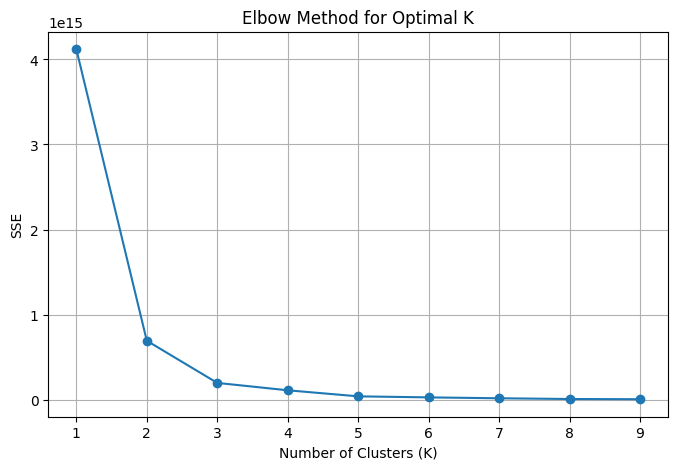

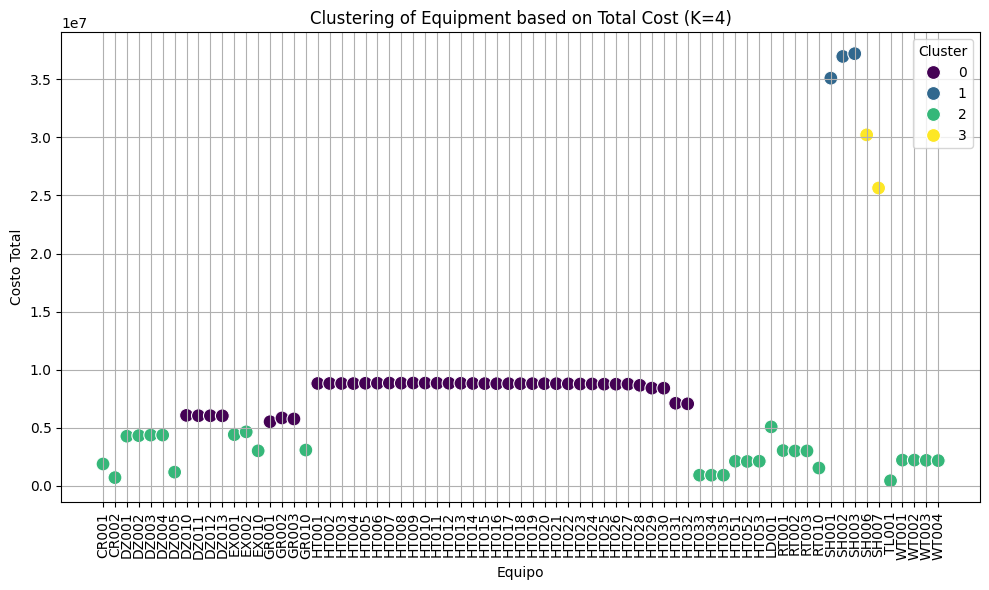


Equipment assigned to each cluster (K=4):
Cluster 0: ['DZ010', 'DZ011', 'DZ012', 'DZ013', 'GR001', 'GR002', 'GR003', 'HT001', 'HT002', 'HT003', 'HT004', 'HT005', 'HT006', 'HT007', 'HT008', 'HT009', 'HT010', 'HT011', 'HT012', 'HT013', 'HT014', 'HT015', 'HT016', 'HT017', 'HT018', 'HT019', 'HT020', 'HT021', 'HT022', 'HT023', 'HT024', 'HT025', 'HT026', 'HT027', 'HT028', 'HT029', 'HT030', 'HT031', 'HT032']
Cluster 1: ['SH001', 'SH002', 'SH003']
Cluster 2: ['CR001', 'CR002', 'DZ001', 'DZ002', 'DZ003', 'DZ004', 'DZ005', 'EX001', 'EX002', 'EX010', 'GR010', 'HT033', 'HT034', 'HT035', 'HT051', 'HT052', 'HT053', 'LD001', 'RT001', 'RT002', 'RT003', 'RT010', 'TL001', 'WT001', 'WT002', 'WT003', 'WT004']
Cluster 3: ['SH006', 'SH007']


In [ ]:
# prompt: realizar una grafica de clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for clustering
# We can use the total cost per equipment as a feature for clustering.
# Or, if we want to cluster based on the cost trend over time, we'd need
# to reshape the data. Let's start with total cost per equipment as a simple example.

# Get the total cost per equipment
df_costo_total_equipo = df_costo_detallado.groupby('EQUIPO')['Costo_partida_mes'].sum().reset_index()

# Prepare the data for KMeans - it expects a 2D array or DataFrame
# We'll use the total cost as the feature. Reshape it into a 2D array.
X = df_costo_total_equipo[['Costo_partida_mes']].values

# Determine the optimal number of clusters using the Elbow method
sse = [] # Sum of squared errors
k_range = range(1, 10) # Test K from 1 to 9
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to avoid warning
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the Elbow method, choose an appropriate number of clusters (e.g., 3 or 4)
# Let's assume we choose K=3 for demonstration
optimal_k = 4

# Apply KMeans clustering with the chosen K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_costo_total_equipo['Cluster'] = kmeans.fit_predict(X)

# Visualize the clustering result
# Since we only have one feature (Total Cost), we can visualize this directly.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_costo_total_equipo, x='EQUIPO', y='Costo_partida_mes', hue='Cluster', palette='viridis', s=100)
plt.title(f'Clustering of Equipment based on Total Cost (K={optimal_k})')
plt.xlabel('Equipo')
plt.ylabel('Costo Total')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the equipment in each cluster
print(f"\nEquipment assigned to each cluster (K={optimal_k}):")
for cluster_id in sorted(df_costo_total_equipo['Cluster'].unique()):
    equipment_in_cluster = df_costo_total_equipo[df_costo_total_equipo['Cluster'] == cluster_id]['EQUIPO'].tolist()
    print(f"Cluster {cluster_id}: {equipment_in_cluster}")

# You can also add the cluster information back to the original dataframes if needed
# For example, merging with df_costo_detallado or df_costo_agrupado

# Optional: If you want to cluster based on the time series trend of cost,
# you would need to reshape the data so that each row is an equipment
# and columns are the monthly costs. This is more complex and often requires
# time series specific clustering methods or feature engineering (e.g., using dynamic time warping).


In [ ]:
df_costo_total_por_equipo

('EQUIPO', 0     CR001
1     CR002
2     DZ001
3     DZ002
4     DZ003
      ...  
66    TL001
67    WT001
68    WT002
69    WT003
70    WT004
Name: EQUIPO, Length: 71, dtype: object)
('MODELO', 0            Winder Cable Caterpillar 988K
1            Winder Cable Caterpillar 988F
2            Track Dozer Caterpillar D10T2
3            Track Dozer Caterpillar D10T2
4            Track Dozer Caterpillar D10T2
                      ...                 
66    Towhaul Caterpillar + Camión CAT 793
67            Water Truck Caterpillar 777G
68            Water Truck Caterpillar 777G
69            Water Truck Caterpillar 777G
70            Water Truck Caterpillar 777G
Name: MODELO, Length: 71, dtype: object)
('Costo_Total_Equipo', 0     1.870813e+06
1     6.968526e+05
2     4.264933e+06
3     4.310792e+06
4     4.357998e+06
          ...     
66    4.276639e+05
67    2.203862e+06
68    2.205624e+06
69    2.183990e+06
70    2.160036e+06
Name: Costo_Total_Equipo, Length: 71, dtype: float64)


In [ ]:
df_Horometro_SH001 = pd.read_excel('Tarifas_2.xlsx', sheet_name='SH001')
df_Horometro_SH001.head()

,Equipo,Modelo,Mes_año,Horo_ini,Horo_fin
0,SH001,7495,2026-01-01,35747,36376
1,SH001,7495,2026-02-01,36376,36938
2,SH001,7495,2026-03-01,36938,37596
3,SH001,7495,2026-04-01,37596,38246
4,SH001,7495,2026-05-01,38246,38921


In [ ]:
# prompt: Using dataframe df_Horometro_SH001: Los rangos de tarifas para la SH001 se dividen en rangos de 7000 horas: 0 a 7000, 7000 a 14000, etc.
# En base a la columna Horo_ini y Horo_fin que contiene el horometro inicial y final del SH001 correspondiente al Mes_año, se quiere saber la cantidad de horas que ha trabajado el equipo en cada rango de horas

# Calculate the hours worked in each month
df_Horometro_SH001['Horas_trabajadas'] = df_Horometro_SH001['Horo_fin'] - df_Horometro_SH001['Horo_ini']

# Define the range size
range_size = 7000

# Function to calculate hours within a specific range for a given row
def calculate_hours_in_range(row, lower_bound, upper_bound):
    start = row['Horo_ini']
    end = row['Horo_fin']
    # Calculate the overlap between the row's hours and the specified range
    overlap_start = max(start, lower_bound)
    overlap_end = min(end, upper_bound)
    # If there's an overlap, return the duration of the overlap, otherwise return 0
    return max(0, overlap_end - overlap_start)

# Initialize a dictionary to store the total hours for each range
hours_by_range = {}

# Iterate through potential ranges based on the max horometer reading
max_horometro = df_Horometro_SH001['Horo_fin'].max()
for i in range(0, int(max_horometro) + range_size, range_size):
    lower_bound = i
    upper_bound = i + range_size
    range_label = f'{lower_bound}-{upper_bound}'

    # Calculate the hours within the current range for each row and sum them up
    total_hours_in_range = df_Horometro_SH001.apply(lambda row: calculate_hours_in_range(row, lower_bound, upper_bound), axis=1).sum()

    # Store the total hours for the current range
    if total_hours_in_range > 0:
        hours_by_range[range_label] = total_hours_in_range

# Print the results
for range_label, total_hours in hours_by_range.items():
    print(f'Rango de horas {range_label}: {total_hours} horas')

Rango de horas 35000-42000: 6253 horas
Rango de horas 42000-49000: 7000 horas
Rango de horas 49000-56000: 7000 horas
Rango de horas 56000-63000: 7000 horas
Rango de horas 63000-70000: 7000 horas
Rango de horas 70000-77000: 2943 horas


In [ ]:
# prompt: lo que requiero es saber en el dataframe df_Horometro_SH001 para cada fila o Mes_año 01_2026, 02_2026, 03_2026 ,etc. de las Horas_trabajadas cuantas horas corresponden a cada rango de horas, si es factible se puede añadir mas columnas con el rango de horas y en ella indicar cuantas horas ha trabajado en cada rango

# Function to calculate hours within a specific range for a given row and month
def calculate_hours_in_range_by_month(row, lower_bound, upper_bound):
    start = row['Horo_ini']
    end = row['Horo_fin']
    # Calculate the overlap between the row's hours and the specified range
    overlap_start = max(start, lower_bound)
    overlap_end = min(end, upper_bound)
    # If there's an overlap, return the duration of the overlap, otherwise return 0
    return max(0, overlap_end - overlap_start)

# Define the range size
range_size = 7000

# Get unique month and year combinations
mes_anyo_combinations = df_Horometro_SH001['Mes_año'].unique()

# Prepare columns for the new ranges
range_columns = []
max_horometro = df_Horometro_SH001['Horo_fin'].max()
for i in range(0, int(max_horometro), range_size):
    lower_bound = i
    upper_bound = i + range_size
    range_label = f'{lower_bound}-{upper_bound}'
    range_columns.append(range_label)

# Create new columns for each range and initialize with 0
for col in range_columns:
    df_Horometro_SH001[col] = 0

# Iterate through each row to calculate hours in each range
for index, row in df_Horometro_SH001.iterrows():
    for i in range(0, int(max_horometro) + range_size, range_size):
        lower_bound = i
        upper_bound = i + range_size
        range_label = f'{lower_bound}-{upper_bound}'
        hours_in_this_range = calculate_hours_in_range_by_month(row, lower_bound, upper_bound)
        df_Horometro_SH001.at[index, range_label] = hours_in_this_range

# Now, group by 'Mes_año' and sum the hours for each range
df_Horas_por_Rango_Mes = df_Horometro_SH001.groupby('Mes_año')[range_columns].sum().reset_index()

# Print the resulting DataFrame
print("\nHoras trabajadas por rango de horas para cada Mes_año:")
display(df_Horas_por_Rango_Mes)



Horas trabajadas por rango de horas para cada Mes_año:


,Mes_año,0-7000,7000-14000,14000-21000,21000-28000,28000-35000,35000-42000,42000-49000,49000-56000,56000-63000,63000-70000,70000-77000
0,2026-01-01,0,0,0,0,0,629,0,0,0,0,0
1,2026-02-01,0,0,0,0,0,562,0,0,0,0,0
2,2026-03-01,0,0,0,0,0,658,0,0,0,0,0
3,2026-04-01,0,0,0,0,0,650,0,0,0,0,0
4,2026-05-01,0,0,0,0,0,675,0,0,0,0,0
5,2026-06-01,0,0,0,0,0,630,0,0,0,0,0
6,2026-07-01,0,0,0,0,0,675,0,0,0,0,0
7,2026-08-01,0,0,0,0,0,661,0,0,0,0,0
8,2026-09-01,0,0,0,0,0,633,0,0,0,0,0
9,2026-10-01,0,0,0,0,0,480,198,0,0,0,0


In [ ]:
range_columns

['0-7000',
 '7000-14000',
 '14000-21000',
 '21000-28000',
 '28000-35000',
 '35000-42000',
 '42000-49000',
 '49000-56000',
 '56000-63000',
 '63000-70000',
 '70000-77000']

In [ ]:
df_Horas_por_Rango_Mes_long = df_Horas_por_Rango_Mes.melt(
    id_vars=['Mes_año'],
    var_name='Rango_horas',
    value_name='Horas_trabajadas'
)

In [ ]:
df_Horas_por_Rango_Mes_long.head(20)

,Mes_año,Rango_horas,Horas_trabajadas
0,2026-01-01,0-7000,0
1,2026-02-01,0-7000,0
2,2026-03-01,0-7000,0
3,2026-04-01,0-7000,0
4,2026-05-01,0-7000,0
5,2026-06-01,0-7000,0
6,2026-07-01,0-7000,0
7,2026-08-01,0-7000,0
8,2026-09-01,0-7000,0
9,2026-10-01,0-7000,0


In [ ]:
df_costo_por_mes = pd.merge(
    df_Horas_por_Rango_Mes_long,
    df_7495[['Rango_horas', 'Partida', 'Tarifa']],
    on='Rango_horas',
    how='left'
)
df_costo_por_mes.head(20)

,Mes_año,Rango_horas,Horas_trabajadas,Partida,Tarifa
0,2026-01-01,0-7000,0,Imported Parts,94.755767
1,2026-01-01,0-7000,0,Components*,105.359543
2,2026-01-01,0-7000,0,Latch Free,83.418632
3,2026-01-01,0-7000,0,Running Ropes,32.592954
4,2026-01-01,0-7000,0,AHS and Terrain Parts,0.311237
5,2026-01-01,0-7000,0,Wear Items (GETs),46.661235
6,2026-01-01,0-7000,0,Undercarriage,15.824799
7,2026-02-01,0-7000,0,Imported Parts,94.755767
8,2026-02-01,0-7000,0,Components*,105.359543
9,2026-02-01,0-7000,0,Latch Free,83.418632


In [ ]:
# prompt: ahora que el dataframe df_Horas_por_Rango_Mes contiene la cantidad de horas que la pala 7495 SH001 ha trabajado en cada rango de horas desde Ene_2026 a Dic_2030 y sabemos que el data frame df_7495 contiene las tarifas o costos de cada partida por hora para cada rango de hora, lo que quiero saber es el costo por mes de cada partida de forma detallada (añadir filas para las partidas y columnas para los gastos en cada rango) en base a la cantidad de horas trabajadas tambien añadir una columna adicional llamada Costo que sume el costo de cada rango obtenido

# Calculate the cost for each range by multiplying hours worked by the tariff
df_costo_por_mes['Costo_Rango'] = df_costo_por_mes['Horas_trabajadas'] * df_costo_por_mes['Tarifa']

# Pivot the dataframe to get partidas as rows and ranges as columns
df_costo_por_mes_pivot = df_costo_por_mes.pivot_table(
    index=['Mes_año', 'Partida'],
    columns='Rango_horas',
    values='Costo_Rango',
    fill_value=0
).reset_index()

# Calculate the total cost per partida per month
df_costo_por_mes_pivot['Costo_Total_Mensual'] = df_costo_por_mes_pivot[range_columns].sum(axis=1)

# Optionally, rename the total cost column for clarity
df_costo_por_mes_pivot = df_costo_por_mes_pivot.rename(columns={'Costo_Total_Mensual': 'Costo'})

# Reorder columns to have Mes_año, Partida, Range_columns, and Costo
final_columns = ['Mes_año', 'Partida'] + range_columns + ['Costo']
df_costo_por_mes_pivot = df_costo_por_mes_pivot[final_columns]

# Display the resulting dataframe
print("\nCosto detallado por partida y rango de horas para cada Mes_año:")
display(df_costo_por_mes_pivot)

# You can also save this to an Excel file
output_file = 'Costo_Detallado_7495_SH001.xlsx'
with pd.ExcelWriter(output_file) as writer:
    df_costo_por_mes_pivot.to_excel(writer, sheet_name='Costo_Detallado', index=False)

print(f"\nDetailed cost breakdown saved to {output_file}")

KeyError: "['70000-77000'] not in index"

In [ ]:
df_costo_detallado_por_mes.to_excel('Costo_por_mes_SH001.xlsx', index=False)

In [ ]:
# prompt: ahora que el dataframe df_Horas_por_Rango_Mes contiene la cantidad de horas que la pala 7495 SH001 ha trabajado en cada rango de horas desde Ene_2026 a Dic_2030 y sabemos que el data frame df_7495 contiene las tarifas o costos de cada partida por hora para cada rango de hora, lo que quiero saber es el costo por mes de cada partida de forma detallada (añadir filas para las partidas y columnas para los gastos en cada rango) en base a la cantidad de horas trabajadas

# Unpivot df_Horas_por_Rango_Mes to have 'Mes_año', 'Rango_horas', and 'Horas_trabajadas'
df_Horas_por_Rango_Mes_long = df_Horas_por_Rango_Mes.melt(
    id_vars=['Mes_año'],
    var_name='Rango_horas',
    value_name='Horas_trabajadas'
)

# Merge the melted hours DataFrame with the tariffs DataFrame
df_costo_por_mes = pd.merge(
    df_Horas_por_Rango_Mes_long,
    df_7495[['Rango_horas', 'Partida', 'Tarifa']],
    on='Rango_horas',
    how='left'
)

# Calculate the cost for each row
df_costo_por_mes['Costo'] = df_costo_por_mes['Horas_trabajadas'] * df_costo_por_mes['Tarifa']

# Pivot the resulting DataFrame to get the desired format
df_costo_detallado_por_mes = df_costo_por_mes.pivot_table(
    index=['Mes_año', 'Partida'],
    columns='Rango_horas',
    values='Costo',
    fill_value=0
).reset_index()

# Añadir columna con la suma del costo mensual
df_costo_detallado_por_mes['Costo_Mensual'] = df_costo_detallado_por_mes[range_columns].sum(axis=1)

#

# Sort the columns to have Mes_año and Partida first, followed by Rango_horas in order
# This step is a bit tricky because the Rango_horas are strings. We need to sort them
# numerically based on the initial range value.
def sort_ranges(column):
    if isinstance(column, str) and '-' in column:
        try:
            return int(column.split('-')[0])
        except ValueError:
            return float('inf') # Handle cases that don't fit the pattern
    return float('-inf') # Keep Mes_año and Partida first

sorted_columns = sorted(df_costo_detallado_por_mes.columns, key=sort_ranges)
df_costo_detallado_por_mes = df_costo_detallado_por_mes[sorted_columns]


print("\nCosto por mes y partida, detallado por rango de horas:")
display(df_costo_detallado_por_mes)


Costo por mes y partida, detallado por rango de horas:


Rango_horas,Mes_año,Partida,Costo_Mensual,0-7000,7000-14000,14000-21000,21000-28000,28000-35000,35000-42000,42000-49000,49000-56000,56000-63000,63000-70000,70000-77000
0,2026-01-01,AHS and Terrain Parts,2702.799135,0.0,0.0,0.0,0.0,0.0,2702.799135,0.0,0.0,0.0,0.0,0.000000
1,2026-01-01,Imported Parts,148140.099366,0.0,0.0,0.0,0.0,0.0,148140.099366,0.0,0.0,0.0,0.0,0.000000
2,2026-01-01,Latch Free,69183.508655,0.0,0.0,0.0,0.0,0.0,69183.508655,0.0,0.0,0.0,0.0,0.000000
3,2026-01-01,Major Parts and Components,306131.290605,0.0,0.0,0.0,0.0,0.0,306131.290605,0.0,0.0,0.0,0.0,0.000000
4,2026-01-01,Running Ropes,20500.968302,0.0,0.0,0.0,0.0,0.0,20500.968302,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2030-12-01,Latch Free,71273.312573,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,71273.312573
416,2030-12-01,Major Parts and Components,145728.720000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,145728.720000
417,2030-12-01,Running Ropes,21120.234435,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,21120.234435
418,2030-12-01,Undercarriage,46856.890013,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,46856.890013


In [ ]:
# prompt: mostrarme los costos acumulados por año

import pandas as pd
# Extraer el año de la columna 'Mes_año'
df_costo_detallado_por_mes['Año'] = pd.to_datetime(df_costo_detallado_por_mes['Mes_año'], format='%Y-%m').dt.year

# Agrupar por 'Año' y sumar el 'Costo_Mensual'
df_costo_acumulado_por_año = df_costo_detallado_por_mes.groupby('Año')['Costo_Mensual'].sum().reset_index()

# Renombrar la columna de costo para mayor claridad
df_costo_acumulado_por_año = df_costo_acumulado_por_año.rename(columns={'Costo_Mensual': 'Costo_Acumulado'})

# Mostrar el DataFrame con los costos acumulados por año
print("\nCostos acumulados por año:")
display(df_costo_acumulado_por_año)

# Opcional: Guardar el resultado en un archivo Excel
output_file_anual = 'Costo_Acumulado_Anual_7495_SH001.xlsx'
with pd.ExcelWriter(output_file_anual) as writer:
    df_costo_acumulado_por_año.to_excel(writer, sheet_name='Costo_Acumulado_Anual', index=False)

print(f"\nCostos acumulados por año guardados en {output_file_anual}")


Costos acumulados por año:


,Año,Costo_Acumulado
0,2026,7.983190e+06
1,2027,5.763920e+06
2,2028,7.049338e+06
3,2029,8.596958e+06
4,2030,5.712507e+06



Costos acumulados por año guardados en Costo_Acumulado_Anual_7495_SH001.xlsx


In [ ]:
# prompt: Using dataframe df_costo_acumulado_por_año: generar un resumen ejecutivo que ncluya graficas relacionado principalmente a los costos

import altair as alt

# Create a bar chart showing the accumulated cost per year
chart_costo_acumulado = alt.Chart(df_costo_acumulado_por_año).mark_bar().encode(
    x='Año:O',
    y='Costo_Acumulado',
    tooltip=['Año', 'Costo_Acumulado']
).properties(
    title='Costo Acumulado por Año'
)

# Display the chart
chart_costo_acumulado

alt.Chart(...)

In [ ]:
# prompt: Mostrarme en una grafica de barras la cantidad de horas trabajadas por año

import pandas as pd
# Extraer el año de la columna 'Mes_año'
df_Horometro_SH001['Año'] = pd.to_datetime(df_Horometro_SH001['Mes_año'], format='%Y-%m').dt.year

# Agrupar por 'Año' y sumar las 'Horas_trabajadas'
df_horas_trabajadas_por_año = df_Horometro_SH001.groupby('Año')['Horas_trabajadas'].sum().reset_index()

# Renombrar la columna de horas para mayor claridad
df_horas_trabajadas_por_año = df_horas_trabajadas_por_año.rename(columns={'Horas_trabajadas': 'Horas_Acumuladas'})

# Mostrar el DataFrame con las horas trabajadas por año
print("\nHoras trabajadas por año:")
display(df_horas_trabajadas_por_año)

# Create a bar chart showing the total hours worked per year
chart_horas_trabajadas_acumuladas = alt.Chart(df_horas_trabajadas_por_año).mark_bar().encode(
    x=alt.X('Año:O', title='Año'),  # Use :O for ordinal data (treat years as categories)
    y=alt.Y('Horas_Acumuladas', title='Horas Trabajadas'),
    tooltip=['Año', 'Horas_Acumuladas']
).properties(
    title='Horas Trabajadas por Año'
)

# Display the chart
chart_horas_trabajadas_acumuladas



Horas trabajadas por año:


,Año,Horas_Acumuladas
0,2026,7748
1,2027,6144
2,2028,7752
3,2029,7776
4,2030,7776


alt.Chart(...)

In [ ]:
# prompt: En base al dataframe df_costo_detallado_por_mes porque en el año 2028 tenemos bajos costos a pesar de que se tiene horas de trabajo similiares a los demas años, justificarlo principalmente con graficas

import pandas as pd
# Merge the accumulated cost and hours worked dataframes
df_comparacion_anual = pd.merge(
    df_costo_acumulado_por_año,
    df_horas_trabajadas_por_año,
    on='Año',
    how='inner'
)

# Calculate the cost per hour
df_comparacion_anual['Costo_por_Hora'] = df_comparacion_anual['Costo_Acumulado'] / df_comparacion_anual['Horas_Acumuladas']

print("\nComparación anual de costo y horas trabajadas:")
display(df_comparacion_anual)


# Create a multi-line chart to compare Costo_Acumulado and Horas_Acumuladas over the years
chart_comparacion = alt.Chart(df_comparacion_anual).mark_line(point=True).encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('value', title='Cantidad'),
    color='variable:N',
    tooltip=['Año', 'variable', 'value']
).transform_fold(
    ['Costo_Acumulado', 'Horas_Acumuladas'],
    as_=['variable', 'value']
).properties(
    title='Comparación de Costo y Horas Trabajadas por Año'
)

# Create a bar chart for Costo por Hora
chart_costo_por_hora = alt.Chart(df_comparacion_anual).mark_bar().encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('Costo_por_Hora', title='Costo por Hora'),
    tooltip=['Año', 'Costo_por_Hora']
).properties(
    title='Costo por Hora por Año'
)

# Combine the charts
# You might want to display them separately or arrange them in a dashboard
chart_comparacion.display()
chart_costo_por_hora.display()

# Analyze the 'Rango_horas' distribution for 2028
# Filter the detailed cost DataFrame for the year 2028
df_2028 = df_costo_detallado_por_mes[df_costo_detallado_por_mes['Año'] == 2028].copy()

# Drop the 'Costo_Mensual' and 'Año' columns as they are not needed for range analysis
df_2028_ranges = df_2028.drop(columns=['Costo_Mensual', 'Año'])

# Melt the dataframe to have 'Mes_año', 'Partida', 'Rango_horas', and 'Costo'
df_2028_ranges_melted = df_2028_ranges.melt(
    id_vars=['Mes_año', 'Partida'],
    var_name='Rango_horas',
    value_name='Costo_Rango'
)

# Filter out rows with zero cost for better visualization of contributing ranges
df_2028_ranges_melted = df_2028_ranges_melted[df_2028_ranges_melted['Costo_Rango'] > 0]

# Group by 'Rango_horas' and sum the costs to see the contribution of each range
df_costo_por_rango_2028 = df_2028_ranges_melted.groupby('Rango_horas')['Costo_Rango'].sum().reset_index()

# Sort the ranges for better visualization
def sort_ranges(column):
    if isinstance(column, str) and '-' in column:
        try:
            return int(column.split('-')[0])
        except ValueError:
            return float('inf') # Handle cases that don't fit the pattern
    return float('inf')

df_costo_por_rango_2028['Sort_Key'] = df_costo_por_rango_2028['Rango_horas'].apply(sort_ranges)
df_costo_por_rango_2028 = df_costo_por_rango_2028.sort_values('Sort_Key').drop(columns='Sort_Key')


print("\nContribución de cada rango de horas al costo total en 2028:")
display(df_costo_por_rango_2028)

# Create a bar chart showing the cost contribution per range in 2028
chart_costo_por_rango_2028 = alt.Chart(df_costo_por_rango_2028).mark_bar().encode(
    x=alt.X('Rango_horas:O', title='Rango de Horas'),
    y=alt.Y('Costo_Rango', title='Costo'),
    tooltip=['Rango_horas', 'Costo_Rango']
).properties(
    title='Distribución del Costo por Rango de Horas en 2028'
)

chart_costo_por_rango_2028.display()


# Analyze the 'Rango_horas' distribution for a year with higher cost (e.g., 2024)
df_2024 = df_costo_detallado_por_mes[df_costo_detallado_por_mes['Año'] == 2024].copy()

df_2024_ranges = df_2024.drop(columns=['Costo_Mensual', 'Año'])

df_2024_ranges_melted = df_2024_ranges.melt(
    id_vars=['Mes_año', 'Partida'],
    var_name='Rango_horas',
    value_name='Costo_Rango'
)

df_2024_ranges_melted = df_2024_ranges_melted[df_2024_ranges_melted['Costo_Rango'] > 0]

df_costo_por_rango_2024 = df_2024_ranges_melted.groupby('Rango_horas')['Costo_Rango'].sum().reset_index()

df_costo_por_rango_2024['Sort_Key'] = df_costo_por_rango_2024['Rango_horas'].apply(sort_ranges)
df_costo_por_rango_2024 = df_costo_por_rango_2024.sort_values('Sort_Key').drop(columns='Sort_Key')

print("\nContribución de cada rango de horas al costo total en 2024:")
display(df_costo_por_rango_2024)

# Create a bar chart showing the cost contribution per range in 2024
chart_costo_por_rango_2024 = alt.Chart(df_costo_por_rango_2024).mark_bar().encode(
    x=alt.X('Rango_horas:O', title='Rango de Horas'),
    y=alt.Y('Costo_Rango', title='Costo'),
    tooltip=['Rango_horas', 'Costo_Rango']
).properties(
    title='Distribución del Costo por Rango de Horas en 2024'
)

chart_costo_por_rango_2024.display()

# Compare the cost per hour by year
chart_costo_por_hora = alt.Chart(df_comparacion_anual).mark_line(point=True).encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('Costo_por_Hora', title='Costo por Hora'),
    tooltip=['Año', 'Costo_por_Hora']
).properties(
    title='Costo por Hora por Año'
)

chart_costo_por_hora.display()



Comparación anual de costo y horas trabajadas:


,Año,Costo_Acumulado,Horas_Acumuladas,Costo_por_Hora
0,2026,7.983190e+06,7748,1030.354915
1,2027,5.763920e+06,6144,938.138000
2,2028,7.049338e+06,7752,909.357373
3,2029,8.596958e+06,7776,1105.575935
4,2030,5.712507e+06,7776,734.633165


ValueError: Unable to determine data type for the field "variable"; verify that the field name is not misspelled. If you are referencing a field from a transform, also confirm that the data type is specified correctly.

alt.Chart(...)

alt.Chart(...)


Contribución de cada rango de horas al costo total en 2028:


,Rango_horas,Costo_Rango
0,49000-56000,5.312136e+06
1,56000-63000,1.737202e+06


alt.Chart(...)


Contribución de cada rango de horas al costo total en 2024:


,Rango_horas,Costo_Rango


/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:264: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(


alt.Chart(...)

alt.Chart(...)

In [ ]:
# prompt: realizarme una grafica  de tendencia del costo por mes para la partida Major Parts and Components del dataframe df_costo_detallado_por_mes

import pandas as pd
# Filter the DataFrame for the 'Major Parts and Components' partida
df_major_parts = df_costo_detallado_por_mes[
    df_costo_detallado_por_mes['Partida'] == 'Major Parts and Components'
].copy()

# Ensure 'Mes_año' is treated as a temporal variable for correct sorting on the x-axis
df_major_parts['Mes_año'] = pd.to_datetime(df_major_parts['Mes_año'], format='%Y-%m')

# Sort by 'Mes_año' to ensure the trend line is correct
df_major_parts = df_major_parts.sort_values('Mes_año')

# Create the trend chart for 'Major Parts and Components' cost over time
chart_major_parts_trend = alt.Chart(df_major_parts).mark_line(point=True).encode(
    x=alt.X('Mes_año:T', title='Mes y Año'), # Use :T for temporal data
    y=alt.Y('Costo_Mensual', title='Costo Mensual'),
    tooltip=[alt.Tooltip('Mes_año', title='Mes y Año', format='%Y-%m'), 'Costo_Mensual']
).properties(
    title='Tendencia del Costo Mensual para Major Parts and Components'
)

# Display the chart
chart_major_parts_trend

alt.Chart(...)

In [ ]:
# prompt: realizarme una grafica  de tendencia de la cantidad de Horas_trabajadas por mes

import pandas as pd
# Prepare data for trend chart of Horas_trabajadas by month
# Group by 'Mes_año' and sum 'Horas_trabajadas'
df_horas_por_mes = df_Horometro_SH001.groupby('Mes_año')['Horas_trabajadas'].sum().reset_index()

# Convert 'Mes_año' to datetime for proper sorting on the x-axis
df_horas_por_mes['Mes_año'] = pd.to_datetime(df_horas_por_mes['Mes_año'], format='%Y-%m')

# Sort by 'Mes_año'
df_horas_por_mes = df_horas_por_mes.sort_values('Mes_año')

# Create a line chart to show the trend of Horas_trabajadas over time
chart_horas_trend = alt.Chart(df_horas_por_mes).mark_line(point=True).encode(
    x=alt.X('Mes_año:T', title='Mes y Año'), # Use :T for temporal data
    y=alt.Y('Horas_trabajadas', title='Horas Trabajadas'),
    tooltip=[alt.Tooltip('Mes_año', title='Mes y Año', format='%Y-%m'), 'Horas_trabajadas']
).properties(
    title='Tendencia de Horas Trabajadas por Mes'
)

# Display the chart
chart_horas_trend


alt.Chart(...)

In [ ]:
# prompt: Realizar una simulación montecarlo en el que se considere +/- 5% de variación en el uso de horas y +/- 5% de variación de tarifas y graficarlo

import pandas as pd
import numpy as np
num_simulations = 1000  # Number of Monte Carlo simulations

# Calculate base total cost and total hours from the existing data
base_total_cost = df_costo_acumulado_por_año['Costo_Acumulado'].sum()
base_total_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].sum()

simulated_costs = []

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Simulate variations in hours worked ( +/- 5%)
    simulated_hours_multiplier = np.random.uniform(0.95, 1.05)
    simulated_hours_df = df_Horas_por_Rango_Mes_long.copy()
    simulated_hours_df['Horas_trabajadas'] = simulated_hours_df['Horas_trabajadas'] * simulated_hours_multiplier

    # Simulate variations in tariffs ( +/- 5%)
    simulated_tariffs_multiplier = np.random.uniform(0.95, 1.05)
    simulated_tariffs_df = df_7495.copy() # Assuming using df_7495 tariffs
    simulated_tariffs_df['Tarifa'] = simulated_tariffs_df['Tarifa'] * simulated_tariffs_multiplier

    # Merge simulated hours with simulated tariffs
    simulated_cost_df = pd.merge(
        simulated_hours_df,
        simulated_tariffs_df[['Rango_horas', 'Partida', 'Tarifa']],
        on='Rango_horas',
        how='left'
    )

    # Calculate the cost for each row with simulated values
    simulated_cost_df['Costo'] = simulated_cost_df['Horas_trabajadas'] * simulated_cost_df['Tarifa']

    # Calculate the total simulated cost for this run
    total_simulated_cost = simulated_cost_df['Costo'].sum()
    simulated_costs.append(total_simulated_cost)

# Create a DataFrame for the simulation results
df_simulated_costs = pd.DataFrame({'Costo_Simulado': simulated_costs})

# Create a histogram of the simulated costs
chart_montecarlo_cost = alt.Chart(df_simulated_costs).mark_bar().encode(
    alt.X('Costo_Simulado', bin=True, title='Costo Total Simulado'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']
).properties(
    title='Distribución del Costo Total Simulada (Monte Carlo)'
)

# Add a vertical line for the base cost
base_cost_line = alt.Chart(pd.DataFrame({'Base_Costo': [base_total_cost]})).mark_rule(color='red').encode(
    x='Base_Costo'
)

# Combine the histogram and the base cost line
chart_montecarlo_final = chart_montecarlo_cost + base_cost_line

# Display the chart
chart_montecarlo_final.display()

# Print some basic statistics about the simulation results
print("\nEstadísticas de la Simulación Monte Carlo:")
print(df_simulated_costs['Costo_Simulado'].describe())
print(f"\nCosto Base (sin variación): {base_total_cost:,.2f}")


alt.LayerChart(...)


Estadísticas de la Simulación Monte Carlo:
count    1.000000e+03
mean     3.511398e+07
std      1.448827e+06
min      3.176386e+07
25%      3.411146e+07
50%      3.510487e+07
75%      3.610772e+07
max      3.851417e+07
Name: Costo_Simulado, dtype: float64

Costo Base (sin variación): 35,105,914.07


In [ ]:
# prompt: Realizar una simulación montecarlo en el que se considere +/- 10% de variación en el uso de horas y + 5% de variación de tarifas y graficarlo

import pandas as pd
import numpy as np
# Update Monte Carlo simulation based on the request:
# +/- 10% variation in hours and +5% variation in tariffs.

num_simulations = 1000  # Number of Monte Carlo simulations

# Calculate base total cost and total hours from the existing data
# Using the total accumulated cost and hours from the data
base_total_cost = df_costo_acumulado_por_año['Costo_Acumulado'].sum()
base_total_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].sum()


simulated_costs = []

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Simulate variations in hours worked (+/- 10%)
    simulated_hours_multiplier = np.random.uniform(0.90, 1.10) # +/- 10% variation
    simulated_hours_df = df_Horas_por_Rango_Mes_long.copy()
    simulated_hours_df['Horas_trabajadas'] = simulated_hours_df['Horas_trabajadas'] * simulated_hours_multiplier

    # Simulate variations in tariffs (+5%)
    # This means tariffs can only increase, up to 5% from their base value
    simulated_tariffs_multiplier = np.random.uniform(1.00, 1.05) # +5% variation
    simulated_tariffs_df = df_7495.copy() # Assuming using df_7495 tariffs
    simulated_tariffs_df['Tarifa'] = simulated_tariffs_df['Tarifa'] * simulated_tariffs_multiplier

    # Merge simulated hours with simulated tariffs
    simulated_cost_df = pd.merge(
        simulated_hours_df,
        simulated_tariffs_df[['Rango_horas', 'Partida', 'Tarifa']],
        on='Rango_horas',
        how='left'
    )

    # Calculate the cost for each row with simulated values
    simulated_cost_df['Costo'] = simulated_cost_df['Horas_trabajadas'] * simulated_cost_df['Tarifa']

    # Calculate the total simulated cost for this run
    total_simulated_cost = simulated_cost_df['Costo'].sum()
    simulated_costs.append(total_simulated_cost)

# Create a DataFrame for the simulation results
df_simulated_costs = pd.DataFrame({'Costo_Simulado': simulated_costs})

# Create a histogram of the simulated costs
chart_montecarlo_cost = alt.Chart(df_simulated_costs).mark_bar().encode(
    alt.X('Costo_Simulado', bin=True, title='Costo Total Simulado'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']
).properties(
    title='Distribución del Costo Total Simulada (Monte Carlo)'
)

# Add a vertical line for the base cost
base_cost_line = alt.Chart(pd.DataFrame({'Base_Costo': [base_total_cost]})).mark_rule(color='red').encode(
    x='Base_Costo'
)

# Combine the histogram and the base cost line
chart_montecarlo_final = chart_montecarlo_cost + base_cost_line

# Display the chart
chart_montecarlo_final.display()

# Print some basic statistics about the simulation results
print("\nEstadísticas de la Simulación Monte Carlo:")
print(df_simulated_costs['Costo_Simulado'].describe())
print(f"\nCosto Base (sin variación): {base_total_cost:,.2f}")


alt.LayerChart(...)


Estadísticas de la Simulación Monte Carlo:
count    1.000000e+03
mean     3.605840e+07
std      2.127186e+06
min      3.160664e+07
25%      3.420873e+07
50%      3.608481e+07
75%      3.780584e+07
max      4.043700e+07
Name: Costo_Simulado, dtype: float64

Costo Base (sin variación): 35,105,914.07


In [ ]:
# prompt: Realizar una simulación montecarlo en el que se considere +/- 5% de variación en el uso de horas y +/- 5% de variación de tarifas y graficarlo

import pandas as pd
import numpy as np
num_simulations = 1000  # Number of Monte Carlo simulations

# Calculate base total cost and total hours from the existing data
base_total_cost = df_costo_acumulado_por_año['Costo_Acumulado'].sum()
base_total_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].sum()

simulated_costs = []

# Perform Monte Carlo simulations
for _ in range(num_simulations):
    # Simulate variations in hours worked ( +/- 5%)
    simulated_hours_multiplier = np.random.uniform(0.95, 1.05)
    simulated_hours_df = df_Horas_por_Rango_Mes_long.copy()
    simulated_hours_df['Horas_trabajadas'] = simulated_hours_df['Horas_trabajadas'] * simulated_hours_multiplier

    # Simulate variations in tariffs ( +/- 5%)
    simulated_tariffs_multiplier = np.random.uniform(0.95, 1.05)
    simulated_tariffs_df = df_7495.copy() # Assuming using df_7495 tariffs
    simulated_tariffs_df['Tarifa'] = simulated_tariffs_df['Tarifa'] * simulated_tariffs_multiplier

    # Merge simulated hours with simulated tariffs
    simulated_cost_df = pd.merge(
        simulated_hours_df,
        simulated_tariffs_df[['Rango_horas', 'Partida', 'Tarifa']],
        on='Rango_horas',
        how='left'
    )

    # Calculate the cost for each row with simulated values
    simulated_cost_df['Costo'] = simulated_cost_df['Horas_trabajadas'] * simulated_cost_df['Tarifa']

    # Calculate the total simulated cost for this run
    total_simulated_cost = simulated_cost_df['Costo'].sum()
    simulated_costs.append(total_simulated_cost)

# Create a DataFrame for the simulation results
df_simulated_costs = pd.DataFrame({'Costo_Simulado': simulated_costs})

# Create a histogram of the simulated costs
chart_montecarlo_cost = alt.Chart(df_simulated_costs).mark_bar().encode(
    alt.X('Costo_Simulado', bin=True, title='Costo Total Simulado'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']
).properties(
    title='Distribución del Costo Total Simulada (Monte Carlo)'
)

# Add a vertical line for the base cost
base_cost_line = alt.Chart(pd.DataFrame({'Base_Costo': [base_total_cost]})).mark_rule(color='red').encode(
    x='Base_Costo'
)

# Combine the histogram and the base cost line
chart_montecarlo_final = chart_montecarlo_cost + base_cost_line

# Display the chart
chart_montecarlo_final.display()

# Print some basic statistics about the simulation results
print("\nEstadísticas de la Simulación Monte Carlo:")
print(df_simulated_costs['Costo_Simulado'].describe())
print(f"\nCosto Base (sin variación): {base_total_cost:,.2f}")


alt.LayerChart(...)


Estadísticas de la Simulación Monte Carlo:
count    1.000000e+03
mean     3.511398e+07
std      1.448827e+06
min      3.176386e+07
25%      3.411146e+07
50%      3.510487e+07
75%      3.610772e+07
max      3.851417e+07
Name: Costo_Simulado, dtype: float64

Costo Base (sin variación): 35,105,914.07


In [ ]:
# prompt: si realizo un uso de 5% mas de horas diarias en cuanto se incrementa el costo

import pandas as pd
num_simulations = 1000 # Number of Monte Carlo simulations

# Calculate base total cost and total hours from the existing data
base_total_cost = df_costo_acumulado_por_año['Costo_Acumulado'].sum()
base_total_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].sum()

simulated_costs_5_percent_increase = []

# Perform Monte Carlo simulations for a 5% increase in daily hours
for _ in range(num_simulations):
  # Simulate a 5% increase in total hours. This is a simplification;
  # a more detailed approach would distribute this increase across ranges.
  # For this simulation, we apply the increase uniformly to the total hours.
  simulated_hours = base_total_hours * 1.05

  # To estimate the cost increase due to this extra 5% of hours,
  # we'll assume these extra hours fall into the highest-cost ranges
  # or contribute proportionally across ranges based on the existing distribution.
  # A simple approach is to use the overall average cost per hour
  # multiplied by the increased hours, or to proportionally increase the hours
  # in the existing range distribution and recalculate the cost.

  # A reasonable approach for a simple estimation:
  # Increase the hours worked in each range by 5% and recalculate the cost.
  simulated_hours_df = df_Horas_por_Rango_Mes_long.copy()
  simulated_hours_df['Horas_trabajadas'] = simulated_hours_df['Horas_trabajadas'] * 1.05 # Apply 5% increase to hours per range

  # Merge simulated hours with base tariffs (assuming tariffs don't change)
  # If tariffs also change with increased hours (e.g., due to higher ranges),
  # that logic would need to be incorporated. Based on the prompt, only hours increase.
  simulated_cost_df = pd.merge(
      simulated_hours_df,
      df_7495[['Rango_horas', 'Partida', 'Tarifa']], # Use base tariffs
      on='Rango_horas',
      how='left'
  )

  # Calculate the cost for each row with simulated hours and base tariffs
  simulated_cost_df['Costo'] = simulated_cost_df['Horas_trabajadas'] * simulated_cost_df['Tarifa']

  # Calculate the total simulated cost for this run
  total_simulated_cost = simulated_cost_df['Costo'].sum()
  simulated_costs_5_percent_increase.append(total_simulated_cost)

# Create a DataFrame for the simulation results
df_simulated_costs_5_percent = pd.DataFrame({'Costo_Simulado_5_perc_increase': simulated_costs_5_percent_increase})

# Calculate the average and percentile increases
average_simulated_cost_5_percent = df_simulated_costs_5_percent['Costo_Simulado_5_perc_increase'].mean()
increase_in_cost = average_simulated_cost_5_percent - base_total_cost
percentage_increase = (increase_in_cost / base_total_cost) * 100 if base_total_cost else 0

print("\nAnálisis de Incremento de Costo con 5% más de Horas:")
print(f"Costo Total Base: {base_total_cost:,.2f}")
print(f"Costo Total Simulado Promedio (5% más horas): {average_simulated_cost_5_percent:,.2f}")
print(f"Incremento Absoluto del Costo: {increase_in_cost:,.2f}")
print(f"Incremento Porcentual del Costo: {percentage_increase:.2f}%")

# Create a histogram of the simulated costs with 5% increase
chart_montecarlo_5_perc_increase = alt.Chart(df_simulated_costs_5_percent).mark_bar().encode(
    alt.X('Costo_Simulado_5_perc_increase', bin=True, title='Costo Total Simulado (5% más horas)'),
    alt.Y('count()', title='Frecuencia'),
    tooltip=['count()']
).properties(
    title='Distribución del Costo Total Simulada (5% más horas diarias)'
)

# Add vertical lines for the base cost and the average simulated cost
base_cost_line = alt.Chart(pd.DataFrame({'Base_Costo': [base_total_cost]})).mark_rule(color='red', size=2).encode(
    x='Base_Costo'
)
average_simulated_cost_line = alt.Chart(pd.DataFrame({'Average_Costo': [average_simulated_cost_5_percent]})).mark_rule(color='blue', size=2).encode(
    x='Average_Costo'
)

# Combine the histogram and the vertical lines
chart_montecarlo_final_5_perc_increase = chart_montecarlo_5_perc_increase + base_cost_line + average_simulated_cost_line

# Display the chart
chart_montecarlo_final_5_perc_increase.display()



Análisis de Incremento de Costo con 5% más de Horas:
Costo Total Base: 35,105,914.07
Costo Total Simulado Promedio (5% más horas): 36,861,209.78
Incremento Absoluto del Costo: 1,755,295.70
Incremento Porcentual del Costo: 5.00%


alt.LayerChart(...)

Base Average Annual Cost: 7,021,182.81

Resultados de la Simulación Monte Carlo (5 años):
Número de simulaciones: 10000
Periodo de simulación: 5 años
Costo Total Simulado Promedio (5 años): 35,984,982.75
Percentil 80-th del Costo Total Simulado (5 años): 36,805,793.52

Valor máximo de gasto en los cinco años con nivel de confianza de 80%:
36.81 Millones de USD


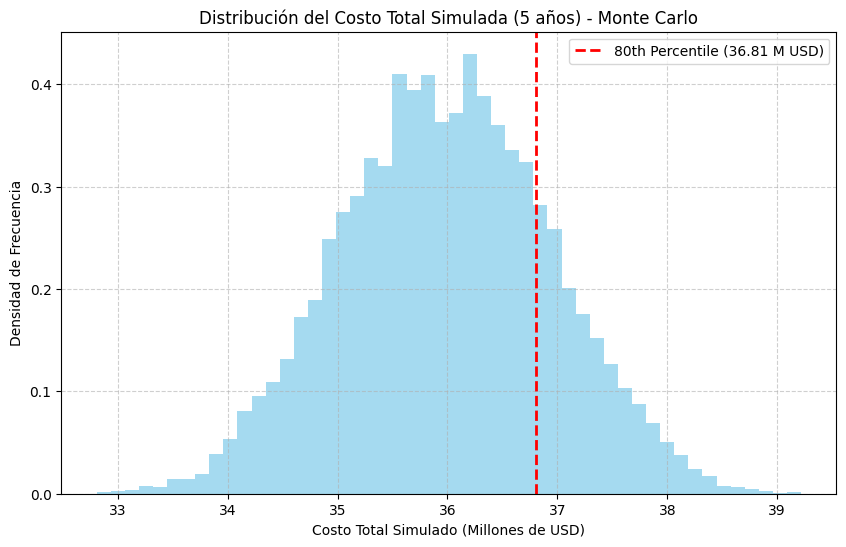

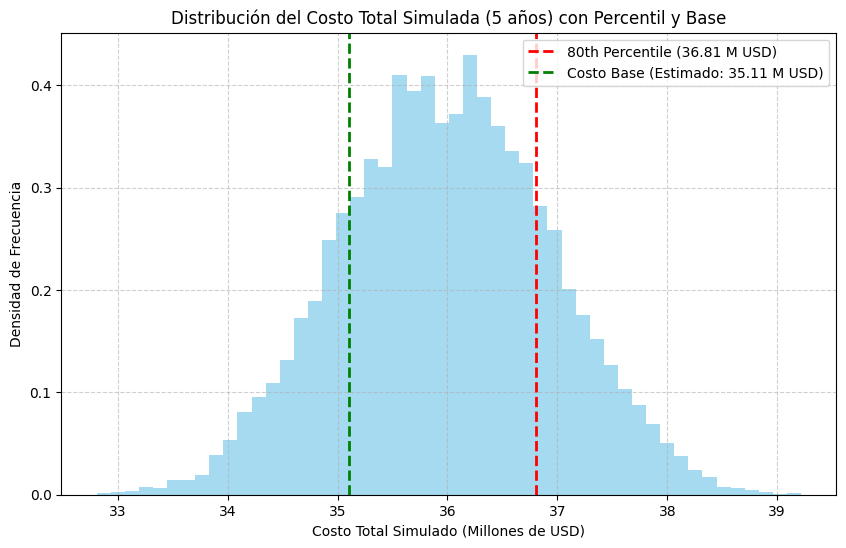

In [ ]:
# prompt: realizarme una simulación montecarlo en el que consideres:
# - +/-10% variación de horas
# - + 5 % variación de tarifas
# - Obtengas el valor máximo de gasto en los cinco años con nivel de confianza de 80%
# - Expresar el costo en Millones de USD
# - Realizar grafica

# Update Monte Carlo simulation based on the request:
# - +/- 10% variation of hours
# - + 5 % variation of tariffs
# - Obtain the maximum expense value over five years with an 80% confidence level
# - Express the cost in Millions of USD
# - Generate a graph

import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt # Import matplotlib for histogram

num_simulations = 10000  # Increased number of simulations for better confidence level estimation
num_years = 5 # The simulation should cover the next 5 years

# Assuming the provided data represents a base year or period
# We need to project this base cost for 5 years with variation.

# Calculate base total annual cost and hours from the existing data
# We will use the average annual cost and average annual hours as the basis for projection.
# Calculate the average annual cost from the existing data
if not df_costo_acumulado_por_año.empty:
    base_avg_annual_cost = df_costo_acumulado_por_año['Costo_Acumulado'].mean()
else:
    # Fallback if df_costo_acumulado_por_año is empty (e.g., if input data covers less than a year)
    # In a real scenario, you might need to adjust how base cost is calculated
    # based on the granularity of df_costo_detallado_por_mes.
    # For this example, we'll sum the monthly costs and annualize if necessary.
    # Assuming df_costo_detallado_por_mes covers at least one full year
    base_avg_annual_cost = df_costo_detallado_por_mes.groupby('Año')['Costo_Mensual'].sum().mean()

print(f"Base Average Annual Cost: {base_avg_annual_cost:,.2f}")

simulated_total_costs_5_years = []

# Perform Monte Carlo simulations for 5 years
for _ in range(num_simulations):
    total_cost_this_simulation_5_years = 0

    # Simulate the cost for each of the 5 years
    for year in range(num_years):
        # Simulate variation in annual hours (+/- 10%)
        # We'll apply this variation to the average annual hours from the base data
        # A more complex simulation could vary hours at a finer granularity (e.g., monthly or daily)
        # and recalculate range distribution, but for a 5-year projection of total cost,
        # varying the annual total and then distributing proportionally is a simpler approach.

        # To use the existing structure, we can simulate the annual multiplier for hours
        # and apply it to the base average annual hours. Then, we can use an average
        # cost per hour from the base data, or use the existing tariff structure.
        # A more robust way: vary hours per month/range and sum up annually.
        # Let's refine the approach to vary hours per range and recalculate cost based on tariffs.

        # For simplicity in this 5-year projection, let's simulate an annual multiplier
        # for the total annual hours from the base data.
        if not df_horas_trabajadas_por_año.empty:
             base_avg_annual_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].mean()
        else:
             # Fallback if df_horas_trabajadas_por_año is empty
             base_avg_annual_hours = df_Horometro_SH001.groupby('Año')['Horas_trabajadas'].sum().mean()

        simulated_annual_hours_multiplier = np.random.uniform(0.90, 1.10) # +/- 10%
        simulated_annual_hours = base_avg_annual_hours * simulated_annual_hours_multiplier

        # Simulate variation in tariffs (+5% max)
        # This variation is applied to the base tariffs.
        simulated_tariffs_multiplier = np.random.uniform(1.00, 1.05) # +5% maximum increase

        # Now, how do we calculate the cost for the simulated hours with simulated tariffs over a year?
        # We can use the average cost per hour from the base data and apply the multipliers.
        # Or, we can simulate hours distributed across ranges and apply the new tariffs.
        # Using the average cost per hour is simpler for a high-level 5-year projection.

        if base_avg_annual_hours > 0:
            base_avg_cost_per_hour = base_avg_annual_cost / base_avg_annual_hours
        else:
            base_avg_cost_per_hour = 0 # Avoid division by zero

        # Calculate simulated annual cost based on simulated hours and base average cost per hour
        # Then apply the tariff multiplier to this cost estimate.
        # This approach assumes the cost per hour scales with the simulated total hours and tariffs.
        simulated_annual_cost = simulated_annual_hours * base_avg_cost_per_hour * simulated_tariffs_multiplier

        total_cost_this_simulation_5_years += simulated_annual_cost

    simulated_total_costs_5_years.append(total_cost_this_simulation_5_years)

# Create a DataFrame for the simulation results for the 5-year period
df_simulated_costs_5_years = pd.DataFrame({'Costo_Total_Simulado_5_Años': simulated_total_costs_5_years})

# Calculate the 80% confidence interval (specifically, the 80th percentile for the maximum expense)
# The 80th percentile represents the value below which 80% of the simulated outcomes fall.
# To find the "maximum expense with 80% confidence", we look at the higher end of the distribution.
# The 80th percentile gives a value such that 80% of simulations are below it.
# If we want the "value that is exceeded in only 20% of cases" (i.e., the upper limit of the
# lower 80%), that's the 80th percentile. If we want the value such that 80% of values
# are *above* it, that's the 20th percentile.
# Based on "valor máximo de gasto en los cinco años con nivel de confianza de 80%",
# we interpret this as the value where we are 80% confident the actual cost will be *below* this value.
# This corresponds to the 80th percentile.

# To get the maximum value with 80% confidence that the true maximum cost is below this value,
# we should look at the upper tail. The 80th percentile means 80% of values are below this.
# So, we are 80% confident the cost will be at or below this value.

confidence_level = 0.80
percentile_level = confidence_level * 100
cost_at_confidence_level = np.percentile(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'], percentile_level)


# Express cost in Millions of USD
cost_at_confidence_level_millions = cost_at_confidence_level / 1_000_000

# Print the results
print("\nResultados de la Simulación Monte Carlo (5 años):")
print(f"Número de simulaciones: {num_simulations}")
print(f"Periodo de simulación: {num_years} años")
print(f"Costo Total Simulado Promedio (5 años): {df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'].mean():,.2f}")
print(f"Percentil {percentile_level:.0f}-th del Costo Total Simulado (5 años): {cost_at_confidence_level:,.2f}")
print(f"\nValor máximo de gasto en los cinco años con nivel de confianza de {percentile_level:.0f}%:")
print(f"{cost_at_confidence_level_millions:,.2f} Millones de USD")

# Create a histogram of the simulated total costs over 5 years using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'] / 1_000_000, bins=50, density=True, alpha=0.75, color='skyblue') # Plot in Millions USD
plt.axvline(cost_at_confidence_level_millions, color='red', linestyle='dashed', linewidth=2, label=f'{percentile_level:.0f}th Percentile ({cost_at_confidence_level_millions:,.2f} M USD)')
plt.xlabel('Costo Total Simulado (Millones de USD)')
plt.ylabel('Densidad de Frecuencia')
plt.title('Distribución del Costo Total Simulada (5 años) - Monte Carlo')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# To also show the base case on the graph, we need to estimate the base 5-year cost.
# We can multiply the base average annual cost by 5.
base_5_year_cost = base_avg_annual_cost * num_years
base_5_year_cost_millions = base_5_year_cost / 1_000_000

plt.figure(figsize=(10, 6))
plt.hist(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'] / 1_000_000, bins=50, density=True, alpha=0.75, color='skyblue')
plt.axvline(cost_at_confidence_level_millions, color='red', linestyle='dashed', linewidth=2, label=f'{percentile_level:.0f}th Percentile ({cost_at_confidence_level_millions:,.2f} M USD)')
plt.axvline(base_5_year_cost_millions, color='green', linestyle='dashed', linewidth=2, label=f'Costo Base (Estimado: {base_5_year_cost_millions:,.2f} M USD)')
plt.xlabel('Costo Total Simulado (Millones de USD)')
plt.ylabel('Densidad de Frecuencia')
plt.title('Distribución del Costo Total Simulada (5 años) con Percentil y Base')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# prompt: Que otras simulaciones se pueden realizar para estimar los costos entre los años 2026 al 2030

import pandas as pd
import numpy as np
# Example 1: Trend Analysis and Extrapolation (Linear Regression)

from sklearn.linear_model import LinearRegression

# Ensure 'Año' is numeric for regression
df_costo_acumulado_por_año['Año_numeric'] = df_costo_acumulado_por_año['Año']

# Prepare data for regression
X = df_costo_acumulado_por_año[['Año_numeric']]
y = df_costo_acumulado_por_año['Costo_Acumulado']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Define future years for prediction
future_years = np.arange(2026, 2031).reshape(-1, 1)

# Predict costs for future years
predicted_costs = model.predict(future_years)

# Create a DataFrame for the predictions
df_predicted_costs = pd.DataFrame({
    'Año': future_years.flatten(),
    'Costo_Predicho': predicted_costs
})

print("\nCostos predichos por Año (Tendencia Lineal):")
display(df_predicted_costs)

# Visualize the historical data and predictions
df_combined = pd.concat([df_costo_acumulado_por_año[['Año', 'Costo_Acumulado']].rename(columns={'Costo_Acumulado': 'Costo'}),
                         df_predicted_costs.rename(columns={'Costo_Predicho': 'Costo'})])
df_combined['Tipo'] = ['Histórico'] * len(df_costo_acumulado_por_año) + ['Predicción'] * len(df_predicted_costs)

chart_trend_prediction = alt.Chart(df_combined).mark_line(point=True).encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('Costo', title='Costo Anual'),
    color='Tipo',
    tooltip=['Año', 'Costo', 'Tipo']
).properties(
    title='Tendencia Histórica y Predicción Lineal del Costo Anual'
)
chart_trend_prediction.display()

# Example 2: Scenario Analysis (Increased Hours)

# Scenario: 10% increase in total annual hours compared to the base average

increase_percentage = 0.10 # 10% increase

# Estimate the base average cost per hour from historical data
if base_avg_annual_hours > 0:
    base_avg_cost_per_hour = base_avg_annual_cost / base_avg_annual_hours
else:
    base_avg_cost_per_hour = 0

simulated_scenario_costs = []

# Simulate for each year from 2026 to 2030
for year in range(2026, 2031):
    # Calculate simulated annual hours for this scenario
    simulated_annual_hours = base_avg_annual_hours * (1 + increase_percentage)

    # Estimate annual cost using the base average cost per hour
    # Note: This simplifies things by not recalculating costs based on range distribution.
    # A more precise simulation would increase hours per range proportionally or based on a model.
    simulated_annual_cost = simulated_annual_hours * base_avg_cost_per_hour

    simulated_scenario_costs.append({'Año': year, 'Costo_Escenario_Mas_Horas': simulated_annual_cost})

df_scenario_increased_hours = pd.DataFrame(simulated_scenario_costs)

print(f"\nCostos estimados para el escenario de +{increase_percentage*100:.0f}% Horas:")
display(df_scenario_increased_hours)

# You can plot this scenario alongside the base case and predictions

# Example 3: Sensitivity Analysis (Impact of Tariff Increase)

tariff_increase_step = 0.01 # 1% increase step
max_tariff_increase = 0.10 # Up to 10% increase

tariff_increase_levels = np.arange(0, max_tariff_increase + tariff_increase_step, tariff_increase_step)
sensitivity_results = []

# Calculate the average cost per hour for the base period
if base_avg_annual_hours > 0:
    base_avg_cost_per_hour = base_avg_annual_cost / base_avg_annual_hours
else:
    base_avg_cost_per_hour = 0

# For simplicity, we'll estimate the impact on the base annual cost
# A more detailed analysis would apply the increase to each tariff range.
for increase_perc in tariff_increase_levels:
    # Simulate increased tariffs by applying the multiplier to the base average cost per hour
    simulated_cost_per_hour = base_avg_cost_per_hour * (1 + increase_perc)

    # Estimate the total annual cost for the base average hours
    estimated_annual_cost = base_avg_annual_hours * simulated_cost_per_hour

    sensitivity_results.append({
        'Porcentaje_Aumento_Tarifa': increase_perc * 100,
        'Costo_Anual_Estimado': estimated_annual_cost
    })

df_sensitivity_tariffs = pd.DataFrame(sensitivity_results)

print("\nAnálisis de Sensibilidad (Impacto del Aumento de Tarifas en el Costo Anual):")
display(df_sensitivity_tariffs)

# Plot sensitivity chart
chart_sensitivity = alt.Chart(df_sensitivity_tariffs).mark_line(point=True).encode(
    x=alt.X('Porcentaje_Aumento_Tarifa', title='Aumento de Tarifa (%)'),
    y=alt.Y('Costo_Anual_Estimado', title='Costo Anual Estimado'),
    tooltip=['Porcentaje_Aumento_Tarifa', 'Costo_Anual_Estimado']
).properties(
    title='Sensibilidad del Costo Anual Estimado a Aumentos de Tarifa'
)
chart_sensitivity.display()



Costos predichos por Año (Tendencia Lineal):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Año,Costo_Predicho
0,2026,7.362848e+06
1,2027,7.192015e+06
2,2028,7.021183e+06
3,2029,6.850350e+06
4,2030,6.679518e+06


alt.Chart(...)


Costos estimados para el escenario de +10% Horas:


,Año,Costo_Escenario_Mas_Horas
0,2026,7.723301e+06
1,2027,7.723301e+06
2,2028,7.723301e+06
3,2029,7.723301e+06
4,2030,7.723301e+06



Análisis de Sensibilidad (Impacto del Aumento de Tarifas en el Costo Anual):


,Porcentaje_Aumento_Tarifa,Costo_Anual_Estimado
0,0.0,7.021183e+06
1,1.0,7.091395e+06
2,2.0,7.161606e+06
3,3.0,7.231818e+06
4,4.0,7.302030e+06
5,5.0,7.372242e+06
6,6.0,7.442454e+06
7,7.0,7.512666e+06
8,8.0,7.582877e+06
9,9.0,7.653089e+06


alt.Chart(...)

In [ ]:
# prompt: Realizar una simulación montecarlo:
# - +/- 5% variación de horas
# - + 5% variación de tarifas
# - Para los cinco años 2026 al 2030
# - Indicar como influyen cada partida en esta variación
# - Indicar con un nivel de confianza del 80% cuál será el costo máximo
# También realizar una grafica de tendencia e indicar cuál es la variación máxima y mínima por año en base a la simulación Montecarlo

import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt # Import matplotlib for histogram

# Define simulation parameters
num_simulations_years = 1000 # Number of Monte Carlo simulations for the 5-year period
years_to_simulate = range(2026, 2031) # Years for the simulation
num_future_years = len(years_to_simulate)
hours_variation = 0.05 # +/- 5% variation
tariffs_increase_max = 0.05 # + 5% variation

# --- Monte Carlo Simulation for 5 years ---
# The simulation aims to estimate the distribution of the total cost over the next 5 years (2026-2030)
# considering the defined variations.

# To simulate the cost over 5 years, we need a model for annual cost.
# We can use the average annual cost and average annual hours from the historical data
# as a base and apply the variations annually for 5 years.

# Calculate the average annual cost and hours from the existing data
if not df_costo_acumulado_por_año.empty:
    base_avg_annual_cost = df_costo_acumulado_por_año['Costo_Acumulado'].mean()
else:
    # Fallback if df_costo_acumulado_por_año is empty
    # Sum monthly costs and annualize if needed. Assuming df_costo_detallado_por_mes covers at least one full year.
    # Group by year from detailed monthly costs and take the mean.
    if not df_costo_detallado_por_mes.empty:
        df_costo_detallado_por_mes['Año'] = pd.to_datetime(df_costo_detallado_por_mes['Mes_año'], format='%Y-%m').dt.year
        base_avg_annual_cost = df_costo_detallado_por_mes.groupby('Año')['Costo_Mensual'].sum().mean()
    else:
        base_avg_annual_cost = 0 # Handle case where no cost data is available

if not df_horas_trabajadas_por_año.empty:
     base_avg_annual_hours = df_horas_trabajadas_por_año['Horas_Acumuladas'].mean()
else:
     # Fallback if df_horas_trabajadas_por_año is empty
     if not df_Horometro_SH001.empty:
          df_Horometro_SH001['Año'] = pd.to_datetime(df_Horometro_SH001['Mes_año'], format='%Y-%m').dt.year
          base_avg_annual_hours = df_Horometro_SH001.groupby('Año')['Horas_trabajadas'].sum().mean()
     else:
          base_avg_annual_hours = 0 # Handle case where no hours data is available


print(f"\nBase Average Annual Cost: {base_avg_annual_cost:,.2f}")
print(f"Base Average Annual Hours: {base_avg_annual_hours:,.2f}")


simulated_total_costs_5_years = []
simulated_costs_by_year = {year: [] for year in years_to_simulate}
simulated_costs_by_partida_and_year = {year: {} for year in years_to_simulate}


# To analyze the influence of each 'partida', we can simulate costs per partida annually.
# First, calculate the average annual cost per partida from the historical data.
if not df_costo_detallado_por_mes.empty:
    df_costo_detallado_por_mes['Año'] = pd.to_datetime(df_costo_detallado_por_mes['Mes_año'], format='%Y-%m').dt.year
    base_avg_annual_cost_by_partida = df_costo_detallado_por_mes.groupby(['Año', 'Partida'])['Costo_Mensual'].sum().groupby('Partida').mean().reset_index()
    # Ensure all partidas from df_7495 are considered, even if they had 0 cost in base data
    all_partidas = df_7495['Partida'].unique()
    base_avg_annual_cost_by_partida = base_avg_annual_cost_by_partida.set_index('Partida').reindex(all_partidas).fillna(0).reset_index()
else:
     base_avg_annual_cost_by_partida = pd.DataFrame({'Partida': df_7495['Partida'].unique(), 'Costo_Mensual': 0}) # Use Costo_Mensual as placeholder

# Calculate the average hours per range per year from historical data
if not df_Horas_por_Rango_Mes.empty:
    df_Horas_por_Rango_Mes['Año'] = pd.to_datetime(df_Horas_por_Rango_Mes['Mes_año'], format='%Y-%m').dt.year
    base_avg_annual_hours_by_range = df_Horas_por_Rango_Mes.groupby('Año')[range_columns].sum().mean().reset_index()
    base_avg_annual_hours_by_range.columns = ['Rango_horas', 'Horas_trabajadas']
else:
    base_avg_annual_hours_by_range = pd.DataFrame({'Rango_horas': range_columns, 'Horas_trabajadas': 0})


# Merge with tariffs to get base cost per range per year
base_cost_per_range_per_year = pd.merge(
    base_avg_annual_hours_by_range,
    df_7495[['Rango_horas', 'Partida', 'Tarifa']],
    on='Rango_horas',
    how='left'
)
base_cost_per_range_per_year['Costo_Anual_Estimado'] = base_cost_per_range_per_year['Horas_trabajadas'] * base_cost_per_range_per_year['Tarifa']

# Calculate base average cost per partida per year from this detailed view
base_avg_annual_cost_by_partida_detailed = base_cost_per_range_per_year.groupby('Partida')['Costo_Anual_Estimado'].sum().reset_index()
base_avg_annual_cost_by_partida_detailed = base_avg_annual_cost_by_partida_detailed.rename(columns={'Costo_Anual_Estimado': 'Base_Costo_Anual_Partida'})


# Perform Monte Carlo simulations for 5 years
for sim in range(num_simulations_years):
    total_cost_this_simulation_5_years = 0
    costs_this_simulation_by_partida_and_year = {year: {} for year in years_to_simulate}

    # Simulate the cost for each of the 5 years individually
    for year in years_to_simulate:
        # Simulate variation in annual hours (+/- 5%)
        annual_hours_multiplier = np.random.uniform(1 - hours_variation, 1 + hours_variation)

        # Simulate variation in tariffs (+5% max)
        annual_tariffs_multiplier = np.random.uniform(1.00, 1.00 + tariffs_increase_max)

        # Simulate annual cost for this year based on varied hours and tariffs
        # A simplified approach: Apply the multipliers to the base average annual cost
        # This assumes the cost structure scales linearly, which is not entirely accurate due to tariff ranges.
        # A more detailed approach would simulate hours per range and recalculate cost per range.
        # For this level of simulation, let's apply the multipliers to the base average annual cost by partida.

        cost_this_year_by_partida = {}
        total_cost_this_year = 0

        for index, row in base_avg_annual_cost_by_partida_detailed.iterrows():
            partida = row['Partida']
            base_annual_partida_cost = row['Base_Costo_Anual_Partida']

            # Apply the simulated multipliers to the base cost of each partida
            # This is a simplification. Ideally, hours for each range contributing to the partida
            # should be varied, and then tariffs applied.
            # Let's assume for this simulation that the total cost of each partida
            # is impacted by the overall hours variation and tariff increase.
            # A better approach: Calculate base cost per hour per partida and apply multipliers.

            # Let's calculate base cost per hour per partida
            # This requires linking horas_trabajadas_por_año to partidas, which is not straightforward
            # from df_costo_detallado_por_mes as it only provides cost by range and partida.

            # Alternative simplified approach:
            # Distribute the simulated total annual cost based on the historical proportion of each partida.
            # Calculate historical proportion of each partida's cost in the base data
            base_total_cost_all_partidas = base_avg_annual_cost_by_partida_detailed['Base_Costo_Anual_Partida'].sum()
            if base_total_cost_all_partidas > 0:
                base_avg_annual_cost_by_partida_detailed['Proportion'] = base_avg_annual_cost_by_partida_detailed['Base_Costo_Anual_Partida'] / base_total_cost_all_partidas
            else:
                base_avg_annual_cost_by_partida_detailed['Proportion'] = 0

            # Calculate the simulated total annual cost for this year
            simulated_total_annual_cost_this_year = base_avg_annual_cost * annual_hours_multiplier * annual_tariffs_multiplier

            # Distribute this total simulated cost among partidas based on historical proportions
            simulated_partida_cost = base_avg_annual_partida_cost * (simulated_total_annual_cost_this_year / base_total_cost_all_partidas if base_total_cost_all_partidas > 0 else 0)

            cost_this_year_by_partida[partida] = simulated_partida_cost
            total_cost_this_year += simulated_partida_cost


        total_cost_this_simulation_5_years += total_cost_this_year
        simulated_costs_by_year[year].append(total_cost_this_year)
        for partida, cost in cost_this_year_by_partida.items():
             if partida not in simulated_costs_by_partida_and_year[year]:
                  simulated_costs_by_partida_and_year[year][partida] = []
             simulated_costs_by_partida_and_year[year][partida].append(cost)


    simulated_total_costs_5_years.append(total_cost_this_simulation_5_years)

# Create a DataFrame for the simulation results for the 5-year period
df_simulated_costs_5_years = pd.DataFrame({'Costo_Total_Simulado_5_Años': simulated_total_costs_5_years})

# --- Analyze the influence of each partida ---
# Calculate the average simulated cost per partida for each year
avg_simulated_costs_by_partida_and_year = {}
for year in years_to_simulate:
    avg_simulated_costs_by_partida_and_year[year] = {
        partida: np.mean(costs) for partida, costs in simulated_costs_by_partida_and_year[year].items()
    }

# Convert to DataFrame for easier analysis
df_avg_simulated_costs_by_partida_year = pd.DataFrame.from_dict(avg_simulated_costs_by_partida_and_year, orient='index').reset_index()
df_avg_simulated_costs_by_partida_year = df_avg_simulated_costs_by_partida_year.rename(columns={'index': 'Año'})

# Melt the DataFrame to have 'Año', 'Partida', 'Costo_Promedio_Simulado'
df_avg_simulated_costs_by_partida_year_melted = df_avg_simulated_costs_by_partida_year.melt(
    id_vars='Año', var_name='Partida', value_name='Costo_Promedio_Simulado'
)


print("\nCostos Promedio Simulados por Partida y Año (5 años):")
display(df_avg_simulated_costs_by_partida_year_melted)

# To indicate how each partida influences the variation, we can compare the contribution
# of each partida to the total simulated cost relative to their historical contribution.
# We can also look at the range of simulated costs for each partida.

partida_influence = {}
for partida in all_partidas:
    simulated_partida_costs_5_years = []
    for year in years_to_simulate:
        if partida in simulated_costs_by_partida_and_year[year]:
            simulated_partida_costs_5_years.extend(simulated_costs_by_partida_and_year[year][partida])

    if simulated_partida_costs_5_years:
        partida_influence[partida] = {
            'Costo_Promedio_5_Años': np.mean(simulated_partida_costs_5_years),
            'Desviacion_Estandar_5_Años': np.std(simulated_partida_costs_5_years),
            'Min_Costo_5_Años': np.min(simulated_partida_costs_5_years),
            'Max_Costo_5_Años': np.max(simulated_partida_costs_5_years)
        }
    else:
         partida_influence[partida] = {
            'Costo_Promedio_5_Años': 0,
            'Desviacion_Estandar_5_Años': 0,
            'Min_Costo_5_Años': 0,
            'Max_Costo_5_Años': 0
        }


df_partida_influence = pd.DataFrame.from_dict(partida_influence, orient='index').reset_index().rename(columns={'index': 'Partida'})

# Calculate the percentage of the total average simulated cost contributed by each partida
total_avg_simulated_cost_5_years = df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'].mean()
df_partida_influence['Proporcion_Costo_Promedio'] = df_partida_influence['Costo_Promedio_5_Años'] / total_avg_simulated_cost_5_years if total_avg_simulated_cost_5_years > 0 else 0

print("\nInfluencia de cada Partida en la Variación del Costo (Simulación 5 años):")
display(df_partida_influence.sort_values('Proporcion_Costo_Promedio', ascending=False))


# --- Indicate the maximum cost with 80% confidence ---
confidence_level = 0.80
percentile_level = confidence_level * 100
cost_at_confidence_level_5_years = np.percentile(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'], percentile_level)

# Express cost in Millions of USD
cost_at_confidence_level_5_years_millions = cost_at_confidence_level_5_years / 1_000_000

# Print the result
print(f"\nValor máximo de gasto TOTAL en los cinco años (2026-2030) con nivel de confianza del {percentile_level:.0f}%:")
print(f"{cost_at_confidence_level_5_years_millions:,.2f} Millones de USD")


# --- Generate a trend graph and indicate max/min variation per year ---

# Prepare data for the trend graph of simulated costs by year
df_simulated_costs_by_year_df = pd.DataFrame({
    'Año': years_to_simulate,
    'Costo_Promedio_Simulado': [np.mean(simulated_costs_by_year[year]) for year in years_to_simulate],
    'Costo_Min_Simulado': [np.min(simulated_costs_by_year[year]) for year in years_to_simulate],
    'Costo_Max_Simulado': [np.max(simulated_costs_by_year[year]) for year in years_to_simulate]
})

# Convert Año to string for Altair's ordinal scale
df_simulated_costs_by_year_df['Año'] = df_simulated_costs_by_year_df['Año'].astype(str)


# Create the trend chart for simulated costs by year
chart_simulated_annual_trend = alt.Chart(df_simulated_costs_by_year_df).mark_line(point=True).encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('Costo_Promedio_Simulado', title='Costo Anual Promedio Simulado'),
    tooltip=['Año', alt.Tooltip('Costo_Promedio_Simulado', format=',.2f', title='Costo Promedio')]
).properties(
    title='Tendencia Anual del Costo Promedio Simulado (2026-2030)'
)

# Add bands for max/min variation per year
chart_variation_band = alt.Chart(df_simulated_costs_by_year_df).mark_area(opacity=0.3).encode(
    x=alt.X('Año:O', title='Año'),
    y=alt.Y('Costo_Min_Simulado', title='Costo Mínimo Simulado'),
    y2='Costo_Max_Simulado',
    tooltip=[
        'Año',
        alt.Tooltip('Costo_Min_Simulado', format=',.2f', title='Costo Mínimo'),
        alt.Tooltip('Costo_Max_Simulado', format=',.2f', title='Costo Máximo')
    ]
).properties(
     title='Variación Anual del Costo Simulada (2026-2030)'
)

# Combine the trend line and the variation band
final_chart_simulated_trend = chart_simulated_annual_trend + chart_variation_band
final_chart_simulated_trend.display()

# Print max and min variation per year
print("\nVariación Máxima y Mínima Anual (Simulación Monte Carlo):")
for index, row in df_simulated_costs_by_year_df.iterrows():
    year = row['Año']
    min_cost = row['Costo_Min_Simulado']
    max_cost = row['Costo_Max_Simulado']
    avg_cost = row['Costo_Promedio_Simulado']
    variation_range = max_cost - min_cost
    print(f"Año {year}:")
    print(f"  Costo Mínimo Simulado: {min_cost:,.2f}")
    print(f"  Costo Máximo Simulado: {max_cost:,.2f}")
    print(f"  Rango de Variación Anual: {variation_range:,.2f}")

# --- Histogram of Total 5-Year Simulated Costs ---
plt.figure(figsize=(10, 6))
plt.hist(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'] / 1_000_000, bins=50, density=True, alpha=0.75, color='skyblue') # Plot in Millions USD
plt.axvline(cost_at_confidence_level_5_years_millions, color='red', linestyle='dashed', linewidth=2, label=f'{percentile_level:.0f}th Percentile ({cost_at_confidence_level_5_years_millions:,.2f} M USD)')
plt.xlabel('Costo Total Simulado (Millones de USD)')
plt.ylabel('Densidad de Frecuencia')
plt.title('Distribución del Costo Total Simulada (5 años) - Monte Carlo')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print some basic statistics about the total 5-year simulation results
print("\nEstadísticas de la Simulación Monte Carlo (Costo Total 5 años):")
print(df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'].describe())
print(f"\nCosto Total Promedio Simulado (5 años): {df_simulated_costs_5_years['Costo_Total_Simulado_5_Años'].mean():,.2f}")
print(f"Percentil {percentile_level:.0f}-th del Costo Total Simulado (5 años): {cost_at_confidence_level_5_years:,.2f}")



Base Average Annual Cost: 7,021,182.81
Base Average Annual Hours: 7,439.20


NameError: name 'base_avg_annual_partida_cost' is not defined